#**Brazil COVID-19 Clinical Data and Diagnosis Prediction, 2020**
**Author:** Anne Marie Bogar<br/>
**Active Project Dates:** July 14-27, 2024<br/>
<br/>
##Summary
During the COVID-19 Pandemic, many hospitals around the world were overwhelmed with patients in their intensive care units. This resulted in many patients not being able to receive the care that they needed in a safe amount of time, leading to millions of deaths worldwide. The goal of this project is to design a Machine Learning model to predict which patients will and will not eventually require admission to the ICU. The prediction will allow for hospitals to prepare for incoming patients as well as discharge patients that don't need intensive care earlier on.
<br/><br/>
##Data
The [data](https://www.kaggle.com/datasets/S%C3%ADrio-Libanes/covid19) is a CSV file containing COVID-19 patient information from three hospitals in Brazil.<br/><br/>
Patient Demographic Information
- PATIENT_VISIT_IDENTIFIER: (numerical) patient identification number
- AGE_ABOVE65: (categorical) 0 for no, 1 for yes
- AGE_PERCENTIL: (categorical)
- GENDER: (categorical) 0 for man, 1 for woman

<br/>Patient Previous Grouped Diseases (categorical, 0 for no and 1 for yes)

| | | |
| ----------- | ----------- | ----------- |
| DISEASE GROUPING 1 | DISEASE GROUPING 2 | DISEASE GROUPING 3 |
| DISEASE GROUPING 4 | DISEASE GROUPING 5 | DISEASE GROUPING 6 |
| HTN (hypertension) | IMMUNOCOMPROMISED | OTHER |

<br/>Blood Results (median, mean, min, max, diff) (numerical)

| | | | | | |
| ----------- | ----------- | ----------- |----------- |----------- |----------- |
| ALBUMIN | BE_ARTERIAL | BE_VENOUS |BIC_ARTERIAL | BIC_VENOUS | BILLIRUBIN |
| BLAST | CALCIUM | CREATININ | FFA | GGT | GLUCOSE |
| HEMATOCRITE | HEMOGRLOBIN | INR | LACTATE | LEUKOCYTES | LINFOCITOS |
| NEUTROPHILES | PO2_ARTERIAL | PO2_VENOUS | PCO2_ARTERIAL | PCO2_VENOUS | PCR |
| PH_ARTERIAL | PH_VENOUS | PLATELETS | POTASSIUM | SATO2_ARTERIAL | SATO2_VENOUS |
| SODIUM | TGO | TGP | TTPA | UREA | DIMER |

<br/>Vital Signs (median, mean, min, max, diff, relative diff) (numerical)

| | | |
| ----------- | ----------- | ----------- |
| BLOODPRESSURE_DIASTOLIC | BLOODPRESSURE_SISTOLIC | HEART_RATE |
| RESPIRATORY_RATE | TEMPERATURE | OXYGEN_SATURATION |

<br/>

- WINDOW: (categorical) the time intervals at which each Blood Result/Vital Signs were taken
- ICU: (cateogrical) target, whether the patient was admitted to the ICU based on their vitals and blood results during that window; 0 for no, 1 for yes

<br/>
Note: each row where the target value = 1 was omitted from the dataset for modelling because the medical staff knew at that point that the patient needed intensive care. For the rows remaining for each patient, the ICU value was changed to whether or not the patient ultimately wound up in the ICU.

#IMPORT & ANALYZE DATA

###IMPORT LIBRARIES
- numpy and pandas for data manipulation
- matplotlib and seaborn for visualization
- scikit-learn for Machine Learning modeling
- imblearn for smoting
- joblib for saving the model
<br/><br/>
- change matplotlib style for cleaner graphics
- change display options for better viewing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import ADASYN
import joblib

#change matplotlib style for cleaner graphics
plt.style.use('seaborn-v0_8')
%matplotlib inline
#change display options for better viewing
pd.options.display.max_columns = None
pd.options.display.max_rows = None

###LOAD DATA
- Import as a pandas dataframe
- Must use read_excel
- Divide dataframe into categorical and numerical features for EDA
- Section off numerical features to keep for ML -> picked from correlation matrix

In [ ]:
uploaded_df = pd.read_excel('Kaggle_Sirio_Libanes_ICU_Prediction.xlsx')

In [ ]:
df = uploaded_df.copy()

In [ ]:
categorical = ['PATIENT_VISIT_IDENTIFIER', 'AGE_ABOVE65',	'AGE_PERCENTIL',	'GENDER',	'DISEASE GROUPING 1',	'DISEASE GROUPING 2',	'DISEASE GROUPING 3',	'DISEASE GROUPING 4',	'DISEASE GROUPING 5',	'DISEASE GROUPING 6',	'HTN',	'IMMUNOCOMPROMISED', 'OTHER', 'WINDOW', 'ICU']
numerical = [x for x in df.columns.tolist() if x not in categorical]
categorical.remove('PATIENT_VISIT_IDENTIFIER')
categorical.remove('ICU')
categorical.remove('WINDOW')
features_to_exclude = ['BILLIRUBIN_MEAN', 'ALBUMIN_MEAN', 'BIC_ARTERIAL_MEAN', 'BIC_VENOUS_MEAN', 'CALCIUM_MEAN', 'HEMATOCRITE_MEAN', 'HEMOGLOBIN_MEAN', 'LACTATE_MEAN', 'LINFOCITOS_MEAN', 'P02_ARTERIAL_MEAN', 'PC02_ARTERIAL_MEAN', 'PC02_VENOUS_MEAN', 'PH_ARTERIAL_MEAN', 'PLATELETS_MEAN', 'SAT02_ARTERIAL_MEAN', 'SAT02_VENOUS_MEAN', 'SODIUM_MEAN', 'BLOODPRESSURE_DIASTOLIC_MEAN', 'HEART_RATE_MEAN', 'OXYGEN_SATURATION_MEAN']
numerical_to_use = [x for x in numerical if 'MEAN' in x and x not in features_to_exclude]

###ANALYZE DATA
- df.describe() -> look at stats (mean, std...), and for missing values
- df.head(70) -> look at dataframe
- df.info() -> look at data types

In [ ]:
df.describe()

,BE_ARTERIAL_MEAN,BE_VENOUS_MEAN,BLAST_MEAN,CREATININ_MEAN,FFA_MEAN,GGT_MEAN,GLUCOSE_MEAN,INR_MEAN,LEUKOCYTES_MEAN,NEUTROPHILES_MEAN,P02_VENOUS_MEAN,PCR_MEAN,PH_VENOUS_MEAN,POTASSIUM_MEAN,TGO_MEAN,TGP_MEAN,TTPA_MEAN,UREA_MEAN,DIMER_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ICU
count,821.000000,821.000000,821.000000,821.000000,821.000000,821.000000,821.000000,821.000000,821.000000,821.000000,821.000000,821.000000,821.000000,821.000000,821.000000,821.000000,821.000000,821.000000,821.000000,1240.000000,1177.000000,1231.000000,1925.000000,1925.000000,1925.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1925.000000
mean,-0.963433,-0.931121,-0.994424,-0.891078,-0.723217,-0.920403,-0.861694,-0.936950,-0.741266,-0.812662,-0.675342,-0.845570,0.369007,-0.525624,-0.991054,-0.982156,-0.822280,-0.830181,-0.954177,-0.332600,-0.438754,0.066893,192.000000,0.467532,0.368831,0.108333,0.028125,0.097917,0.019792,0.128125,0.046875,0.213021,0.158333,0.809896,0.267532
std,0.160870,0.169509,0.098000,0.115901,0.171244,0.152341,0.115752,0.086125,0.149095,0.146085,0.152190,0.245238,0.130906,0.188882,0.074863,0.071975,0.115288,0.150934,0.123582,0.274102,0.217113,0.242858,111.168431,0.499074,0.482613,0.310882,0.165373,0.297279,0.139320,0.334316,0.211426,0.409549,0.365148,0.392485,0.442787
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.000000,-1.000000,-1.000000,-0.930644,-0.742004,-0.958528,-0.891993,-0.959849,-0.832368,-0.896759,-0.704142,-0.982231,0.363636,-0.629630,-0.996827,-0.993521,-0.846633,-0.898795,-0.978877,-0.523077,-0.552542,-0.102991,96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,-1.000000,-1.000000,-1.000000,-0.909413,-0.742004,-0.958528,-0.891993,-0.959849,-0.773658,-0.847139,-0.704142,-0.942911,0.363636,-0.518519,-0.995428,-0.986662,-0.846633,-0.874699,-0.978029,-0.374405,-0.502825,0.035714,192.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,-1.000000,-0.958115,-1.000000,-0.886766,-0.742004,-0.956776,-0.891993,-0.932246,-0.702588,-0.780312,-0.704142,-0.815123,0.363636,-0.444444,-0.994961,-0.984756,-0.836512,-0.812048,-0.968315,-0.184615,-0.383289,0.205890,288.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,384.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_MEAN,CREATININ_MIN,CREATININ_MAX,CREATININ_DIFF,FFA_MEDIAN,FFA_MEAN,FFA_MIN,FFA_MAX,FFA_DIFF,GGT_MEDIAN,GGT_MEAN,GGT_MIN,GGT_MAX,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_MEAN,GLUCOSE_MIN,GLUCOSE_MAX,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_MEAN,HEMATOCRITE_MIN,HEMATOCRITE_MAX,HEMATOCRITE_DIFF,HEMOGLOBIN_MEDIAN,HEMOGLOBIN_MEAN,HEMOGLOBIN_MIN,HEMOGLOBIN_MAX,HEMOGLOBIN_DIFF,INR_MEDIAN,INR_MEAN,INR_MIN,INR_MAX,INR_DIFF,LACTATE_MEDIAN,LACTATE_MEAN,LACTATE_MIN,LACTATE_MAX,LACTATE_DIFF,LEUKOCYTES_MEDIAN,LEUKOCYTES_MEAN,LEUKOCYTES_MIN,LEUKOCYTES_MAX,LEUKOCYTES_DIFF,LINFOCITOS_MEDIAN,LINFOCITOS_MEAN,LINFOCITOS_MIN,LINFOCITOS_MAX,LINFOCITOS_DIFF,NEUTROPHILES_MEDIAN,NEUTROPHILES_MEAN,NEUTROPHILES_MIN,NEUTROPHILES_MAX,NEUTROPHILES_DIFF,P02_ARTERIAL_MEDIAN,P02_ARTERIAL_MEAN,P02_ARTERIAL_MIN,P02_ARTERIAL_MAX,P02_ARTERIAL_DIFF,P02_VENOUS_MEDIAN,P02_VENOUS_MEAN,P02_VENOUS_MIN,P02_VENOUS_MAX,P02_VENOUS_DIFF,PC02_ARTERIAL_MEDIAN,PC02_ARTERIAL_MEAN,PC02_ARTERIAL_MIN,PC02_ARTERIAL_MAX,PC02_ARTERIAL_DIFF,PC02_VENOUS_MEDIAN,PC02_VENOUS_MEAN,PC02_VENOUS_MIN,PC02_VENOUS_MAX,PC02_VENOUS_DIFF,PCR_MEDIAN,PCR_MEAN,PCR_MIN,PCR_MAX,PCR_DIFF,PH_ARTERIAL_MEDIAN,PH_ARTERIAL_MEAN,PH_ARTERIAL_MIN,PH_ARTERIAL_MAX,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_MEAN,PH_VENOUS_MIN,PH_VENOUS_MAX,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_MEAN,PLATELETS_MIN,PLATELETS_MAX,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_MEAN,POTASSIUM_MIN,POTASSIUM_MAX,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_MEAN,SAT02_ARTERIAL_MIN,SAT02_ARTERIAL_MAX,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_MEAN,SAT02_VENOUS_MIN,SAT02_VENOUS_MAX,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_MEAN,SODIUM_MIN,SODIUM_MAX,SODIUM_DIFF,TGO_MEDIAN,TGO_MEAN,TGO_MIN,TGO_MAX,TGO_DIFF,TGP_MEDIAN,TGP_MEAN,TGP_MIN,TGP_MAX,TGP_DIFF,TTPA_MEDIAN,TTPA_MEAN,TTPA_MIN,TTPA_MAX,TTPA_DIFF,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,UREA_DIFF,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,0.555556,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(227), int64(4)
memory usage: 3.4 MB


#PREPROCESSING
- Duplicates
- Missing Values
- Anomalies and Noise

###REMOVE DUPLICATES

In [ ]:
df.duplicated().sum()

0

###CATEGORICAL ENCODING
- encode AGE_PERCENTIL by taking off 'th', changing to an int and changing 'Abover 90th' to 100
- encode WINDOW using intervals similar to the time intervals expressed in the category (1 for 0-2, 3 for 2-4, 5 for 4-6, 9 for 6-12 and 15 for ABOVE_12

In [ ]:
df['AGE_PERCENTIL'] = [100 if x == 'Above 90th' else int(x[:2]) for x in df['AGE_PERCENTIL']]
df['WINDOW'] = [1 if x == '0-2' else 3 if x == '2-4' else 5 if x == '4-6' else 9 if x == '6-12' else 15 for x in df['WINDOW']]

###SCALING
- Min/Max Scale AGE_PERCENTIL and WINDOW to better fit with the other Min/Max scaled features

In [ ]:
mscaler = MinMaxScaler()
df['AGE_PERCENTIL'] = mscaler.fit_transform(df[['AGE_PERCENTIL']])
df['WINDOW'] = mscaler.fit_transform(df[['WINDOW']])

###MISSING VALUES
- imputation using backfill and frontfill
- change all ICU values to last ICU value for patient to better predict the outcome
- exlcude all rows in which the original ICU target value is 1

In [ ]:
icu_win = []
per_patient = df.groupby(['PATIENT_VISIT_IDENTIFIER'], dropna=False)
new_df = pd.DataFrame()
first_hours = pd.DataFrame()
for patient, info in per_patient:
  icu_windows = len(info[info['ICU'] == 1])
  icu_win.append(icu_windows)
  info['ICU'] = [info['ICU'].iloc[-1] for x in info['ICU']]
  info = info.bfill()
  info = info.ffill()
  if not info.isnull().values.any():
    new_df = pd.concat([new_df, info.iloc[1:5-icu_windows]])
    if icu_windows != 5:
      first_hours = pd.concat([first_hours, info.iloc[:1]])

In [ ]:
new_df.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_MEAN,CREATININ_MIN,CREATININ_MAX,CREATININ_DIFF,FFA_MEDIAN,FFA_MEAN,FFA_MIN,FFA_MAX,FFA_DIFF,GGT_MEDIAN,GGT_MEAN,GGT_MIN,GGT_MAX,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_MEAN,GLUCOSE_MIN,GLUCOSE_MAX,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_MEAN,HEMATOCRITE_MIN,HEMATOCRITE_MAX,HEMATOCRITE_DIFF,HEMOGLOBIN_MEDIAN,HEMOGLOBIN_MEAN,HEMOGLOBIN_MIN,HEMOGLOBIN_MAX,HEMOGLOBIN_DIFF,INR_MEDIAN,INR_MEAN,INR_MIN,INR_MAX,INR_DIFF,LACTATE_MEDIAN,LACTATE_MEAN,LACTATE_MIN,LACTATE_MAX,LACTATE_DIFF,LEUKOCYTES_MEDIAN,LEUKOCYTES_MEAN,LEUKOCYTES_MIN,LEUKOCYTES_MAX,LEUKOCYTES_DIFF,LINFOCITOS_MEDIAN,LINFOCITOS_MEAN,LINFOCITOS_MIN,LINFOCITOS_MAX,LINFOCITOS_DIFF,NEUTROPHILES_MEDIAN,NEUTROPHILES_MEAN,NEUTROPHILES_MIN,NEUTROPHILES_MAX,NEUTROPHILES_DIFF,P02_ARTERIAL_MEDIAN,P02_ARTERIAL_MEAN,P02_ARTERIAL_MIN,P02_ARTERIAL_MAX,P02_ARTERIAL_DIFF,P02_VENOUS_MEDIAN,P02_VENOUS_MEAN,P02_VENOUS_MIN,P02_VENOUS_MAX,P02_VENOUS_DIFF,PC02_ARTERIAL_MEDIAN,PC02_ARTERIAL_MEAN,PC02_ARTERIAL_MIN,PC02_ARTERIAL_MAX,PC02_ARTERIAL_DIFF,PC02_VENOUS_MEDIAN,PC02_VENOUS_MEAN,PC02_VENOUS_MIN,PC02_VENOUS_MAX,PC02_VENOUS_DIFF,PCR_MEDIAN,PCR_MEAN,PCR_MIN,PCR_MAX,PCR_DIFF,PH_ARTERIAL_MEDIAN,PH_ARTERIAL_MEAN,PH_ARTERIAL_MIN,PH_ARTERIAL_MAX,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_MEAN,PH_VENOUS_MIN,PH_VENOUS_MAX,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_MEAN,PLATELETS_MIN,PLATELETS_MAX,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_MEAN,POTASSIUM_MIN,POTASSIUM_MAX,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_MEAN,SAT02_ARTERIAL_MIN,SAT02_ARTERIAL_MAX,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_MEAN,SAT02_VENOUS_MIN,SAT02_VENOUS_MAX,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_MEAN,SODIUM_MIN,SODIUM_MAX,SODIUM_DIFF,TGO_MEDIAN,TGO_MEAN,TGO_MIN,TGO_MAX,TGO_DIFF,TGP_MEDIAN,TGP_MEAN,TGP_MIN,TGP_MAX,TGP_DIFF,TTPA_MEDIAN,TTPA_MEAN,TTPA_MIN,TTPA_MAX,TTPA_DIFF,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,UREA_DIFF,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
1,0,1,0.555556,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.183673,0.183673,0.183673,0.183673,-1.0,-0.868365,-0.868365

In [ ]:
#check target value ratio to determine whether smoting is required
new_df['ICU'].value_counts()

ICU
0    756
1    294
Name: count, dtype: int64

###EXPLORATORY DATA ANALYSIS (EDA)
- Histograms to look at distribution for numerical features
- Scatterplotss to determine whether numerical features affect ICU outcome
- Barplots to look at how the categorical features affect the ICU outcome

In [ ]:
icu_no = [x for x in icu_win if x == 0]
icu_yes = [x for x in icu_win if x != 0]
print("Percentage of ICU cases caught in first 2 hours: {:.2f}%".format((icu_yes.count(1)/len(icu_yes))*100))
print("Percentage of ICU cases caught in first 4 hours: {:.2f}%".format(((icu_yes.count(1)+icu_yes.count(3))/len(icu_yes))*100))
print("Percentage of patients that did not need to stay at the hospital for 12+ hours: {:.2f}%".format((len(icu_no)/len(icu_win))*100))

Percentage of ICU cases caught in first 2 hours: 33.33%
Percentage of ICU cases caught in first 4 hours: 53.85%
Percentage of patients that did not need to stay at the hospital for 12+ hours: 49.35%


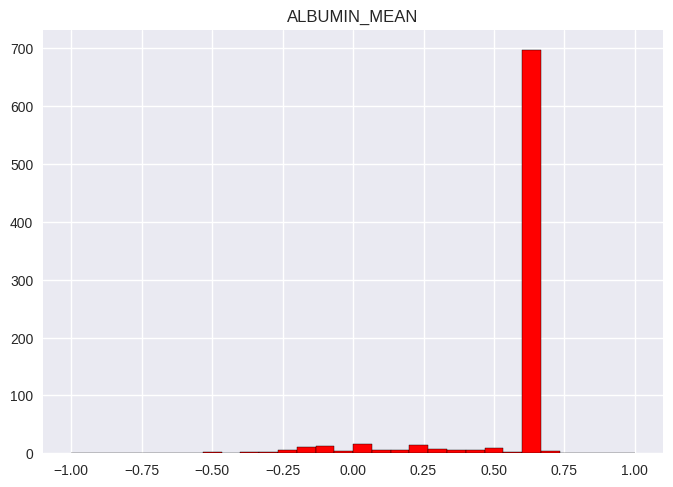

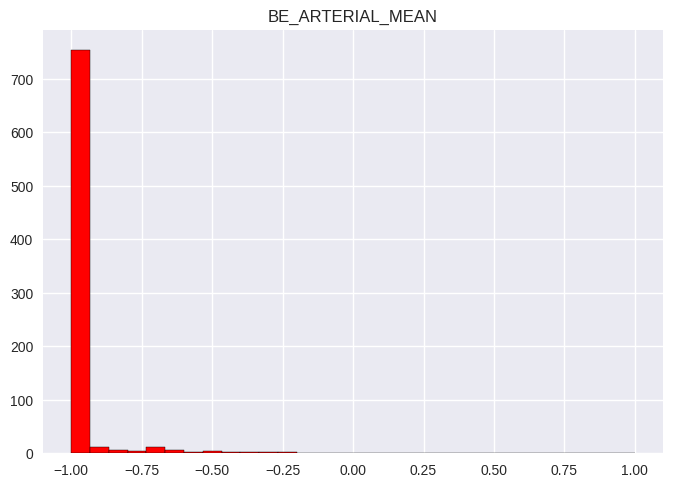

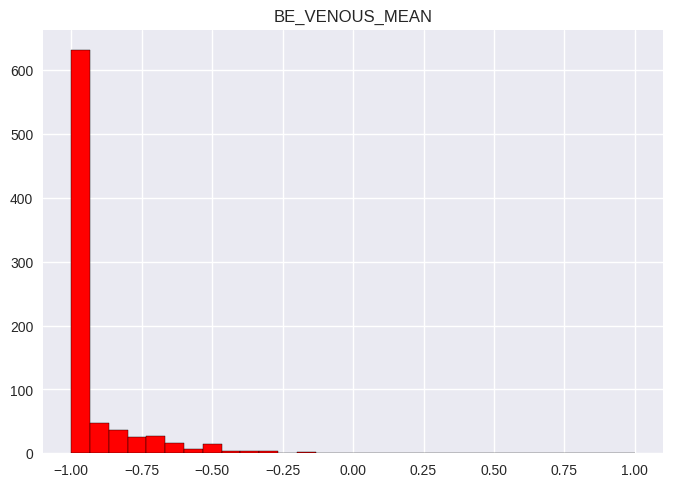

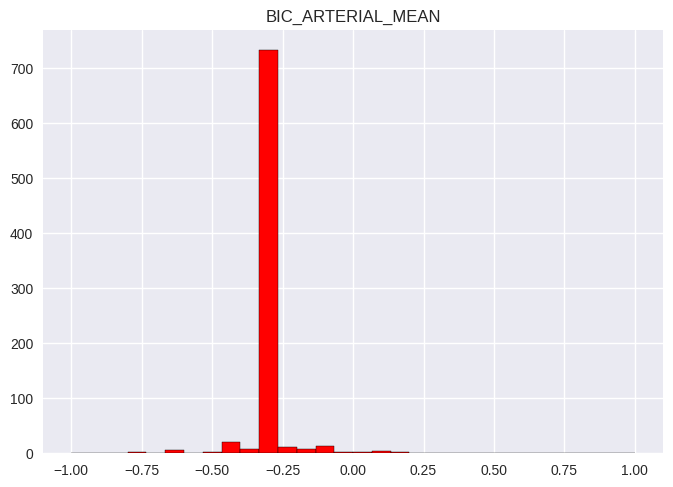

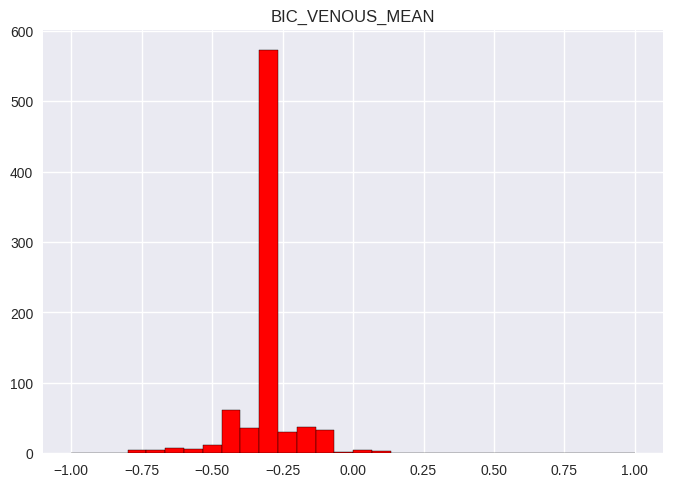

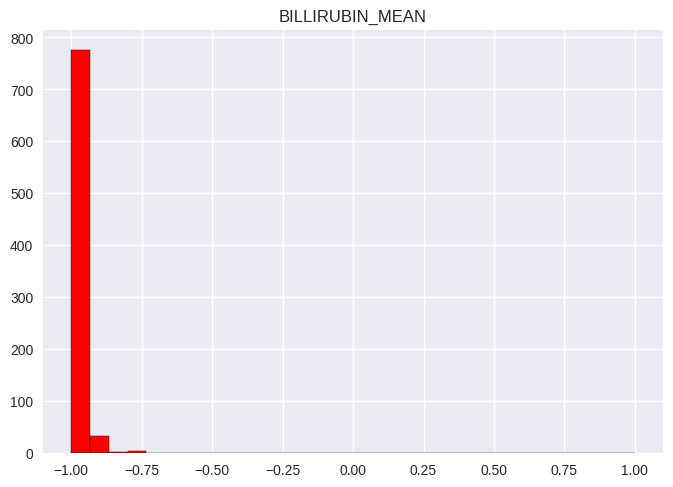

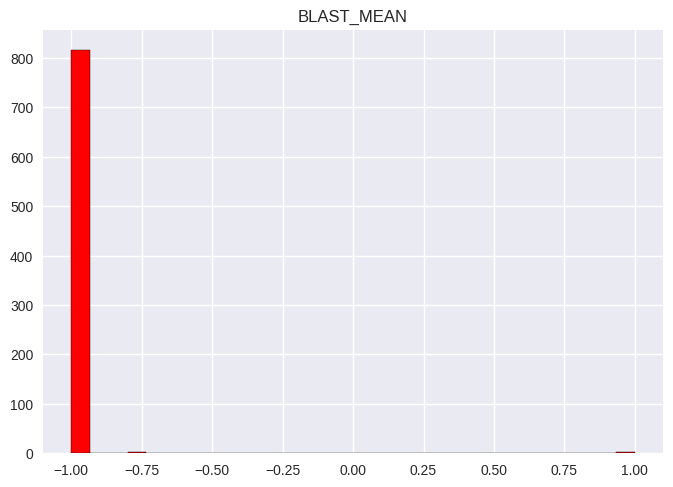

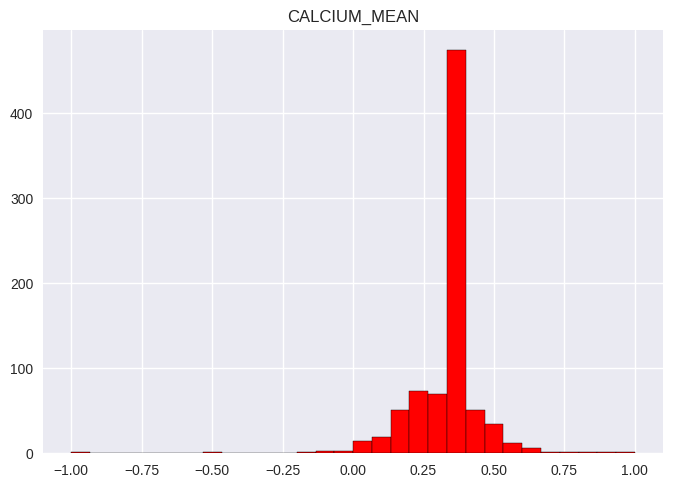

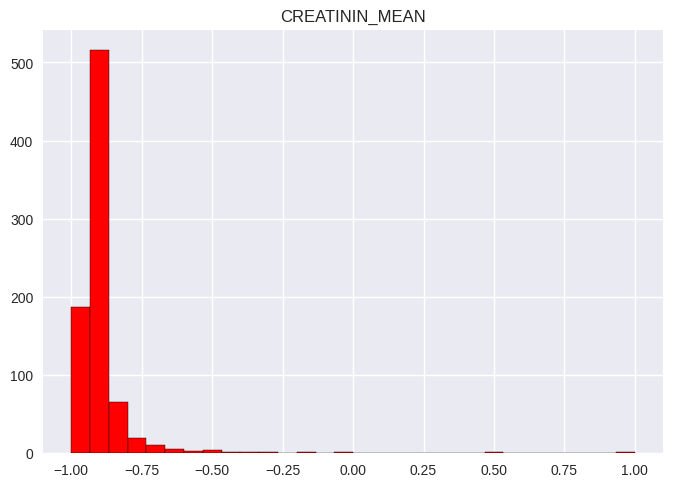

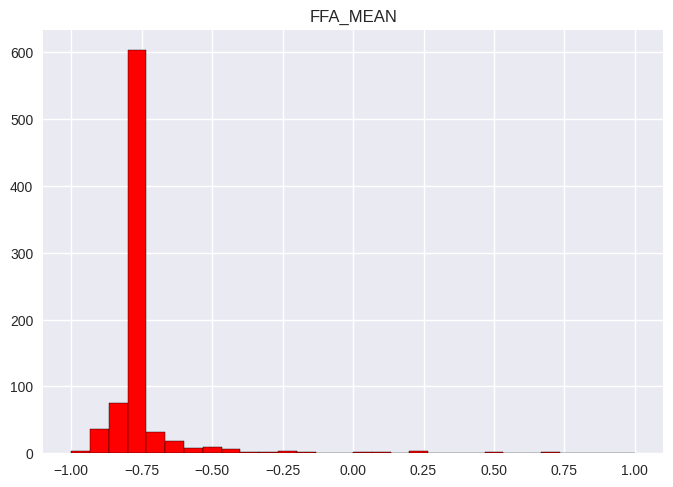

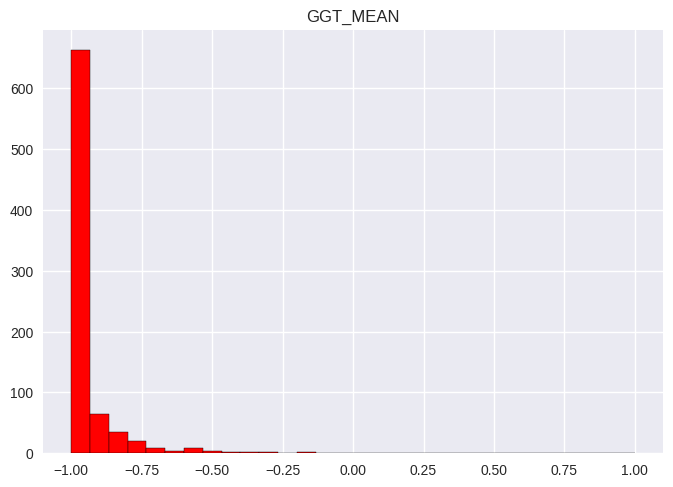

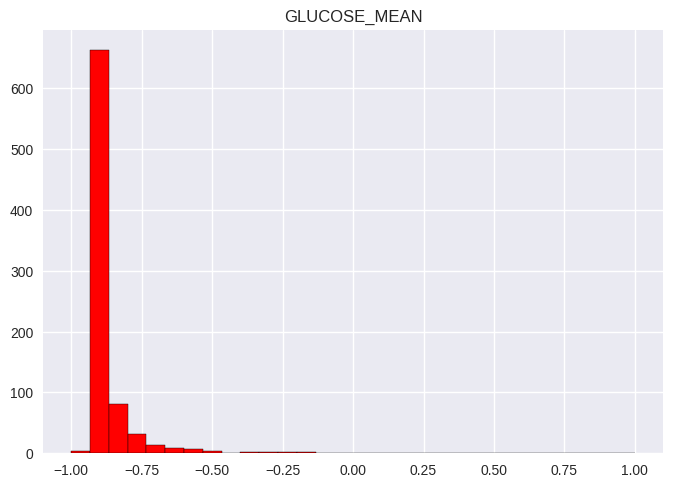

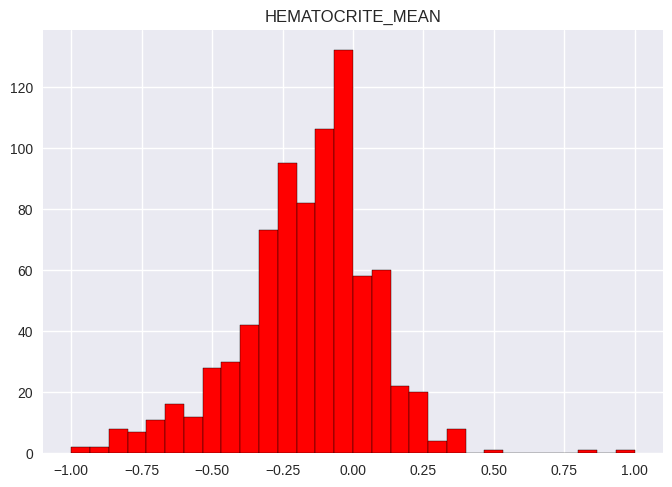

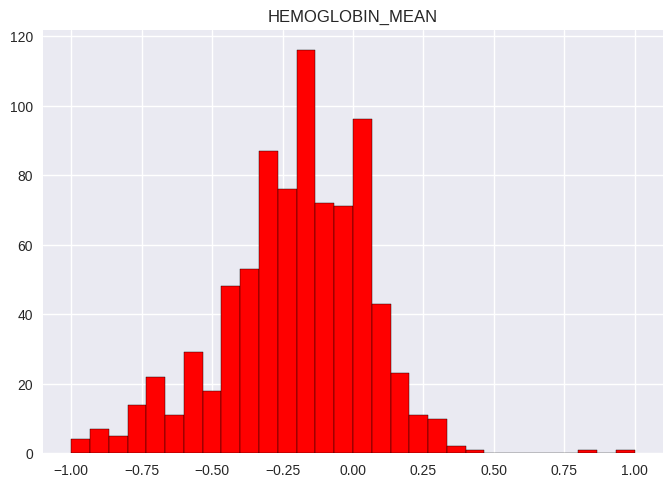

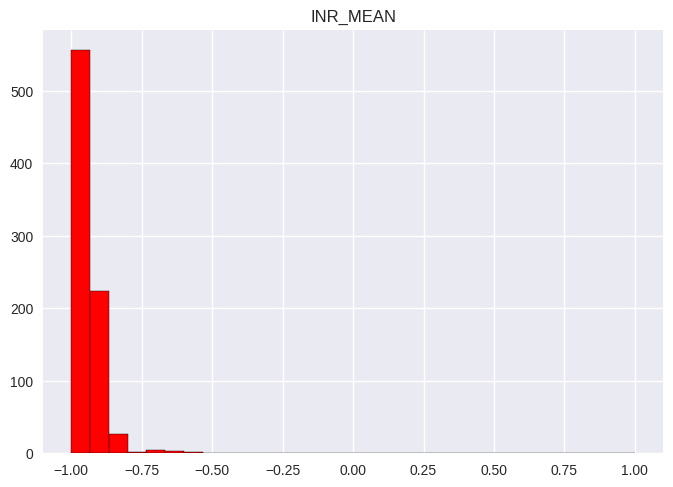

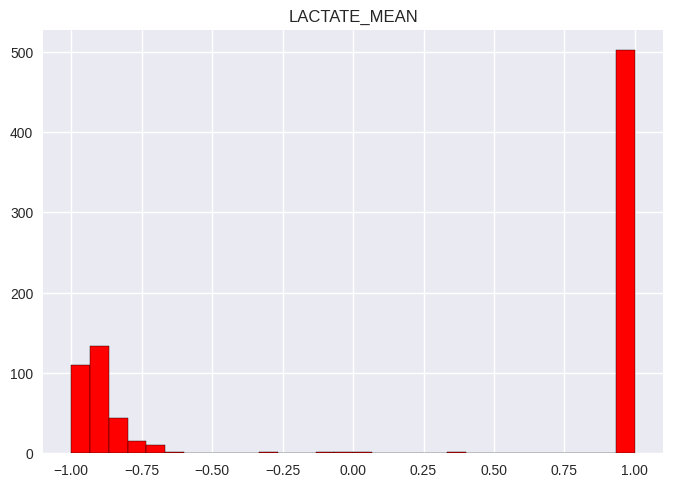

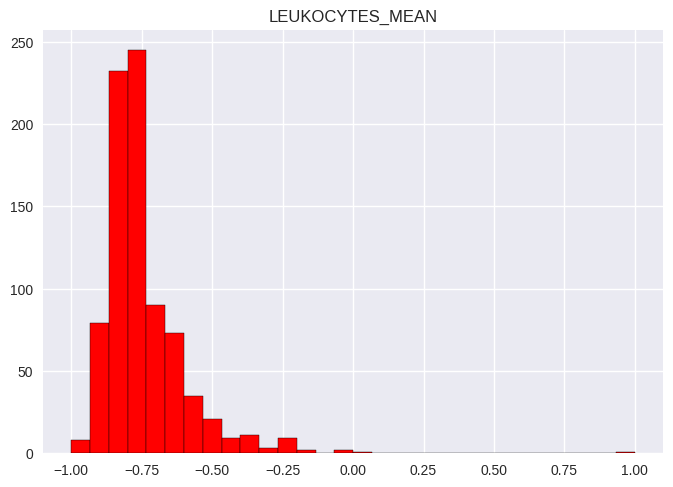

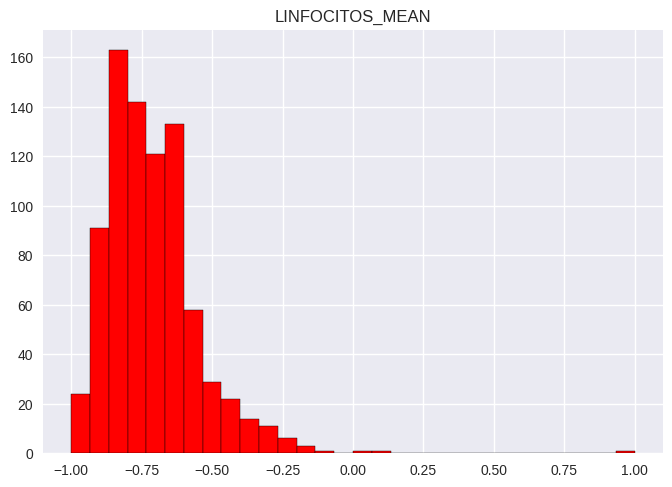

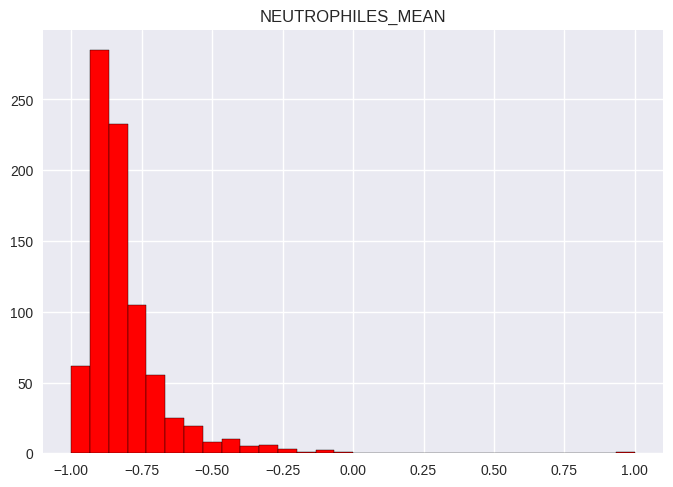

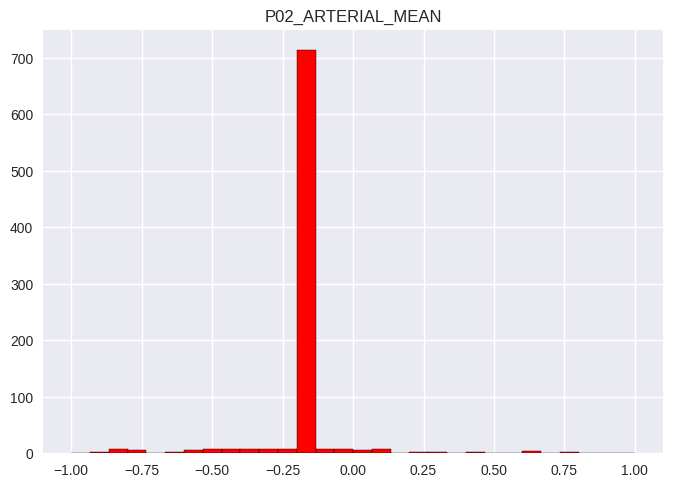

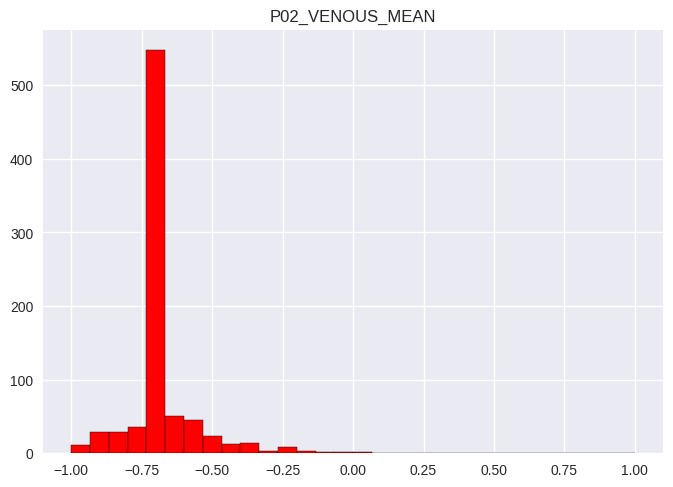

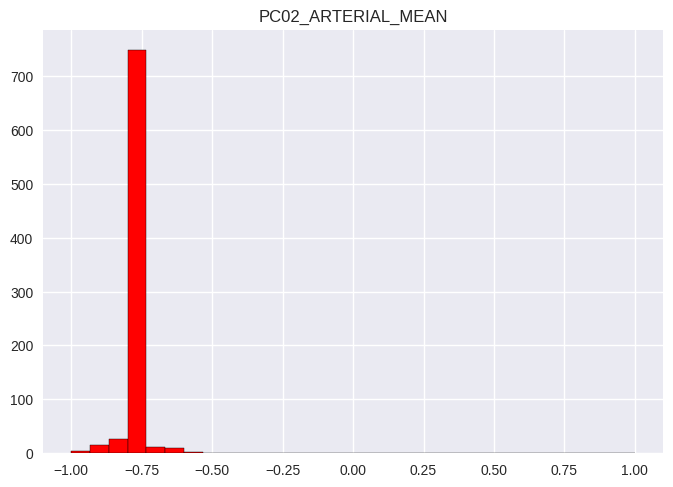

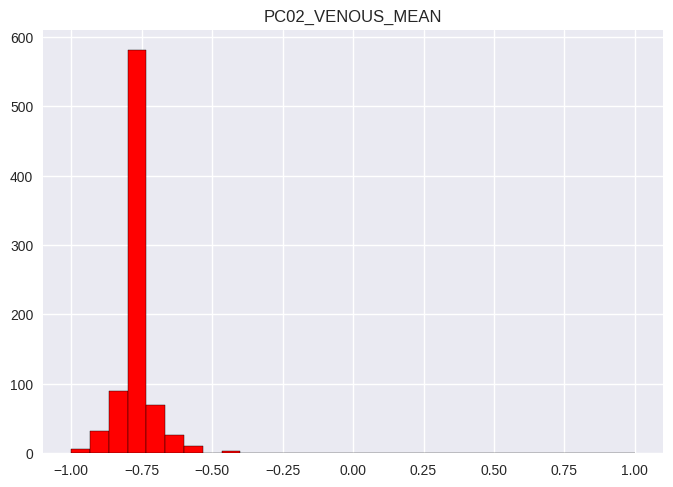

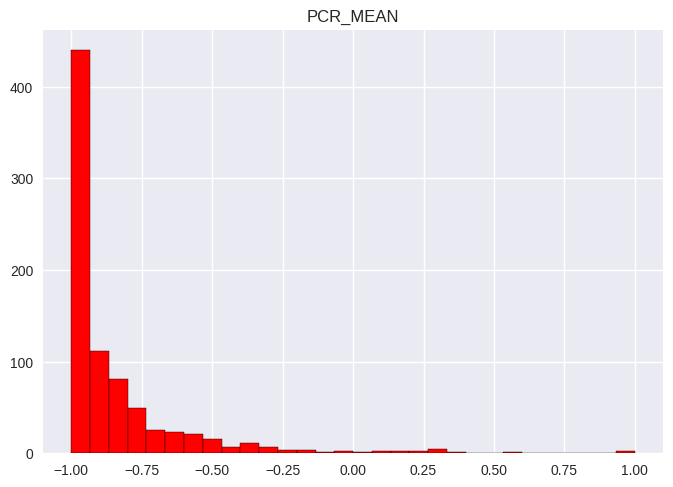

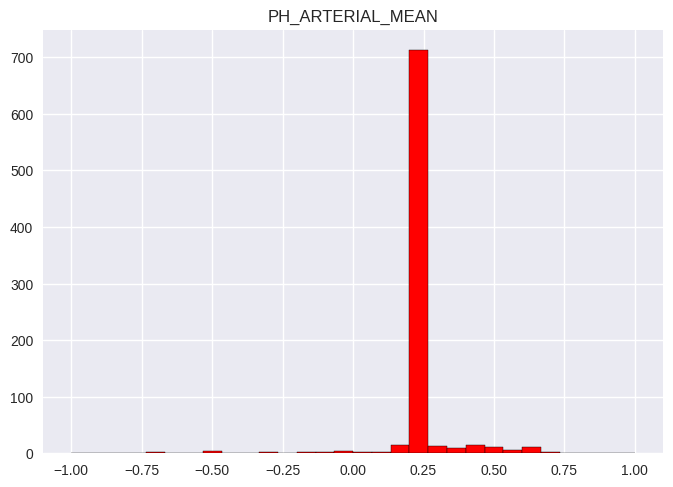

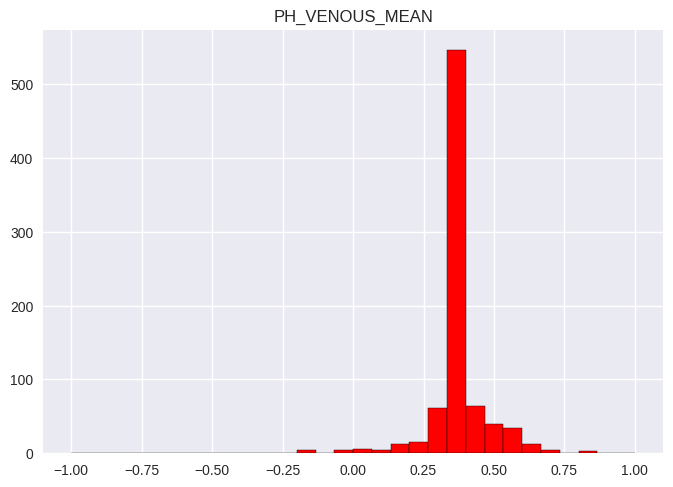

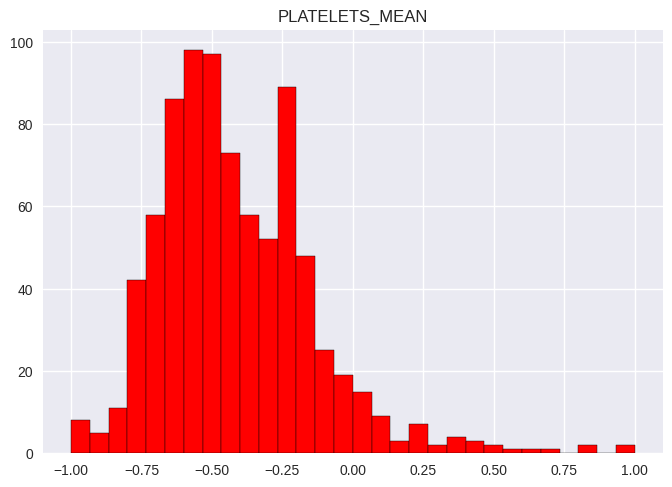

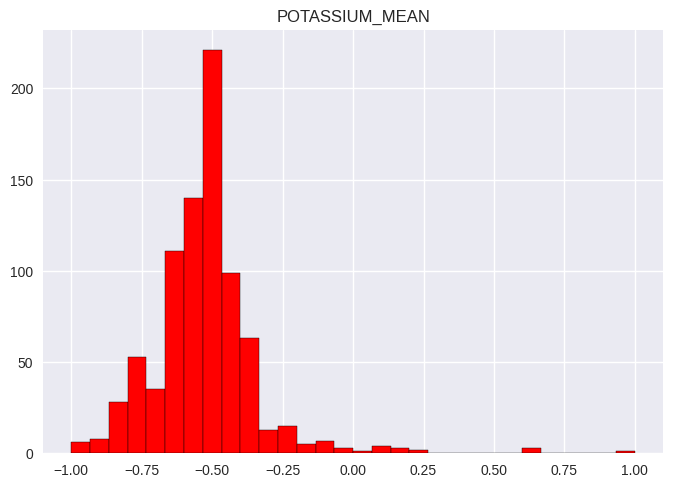

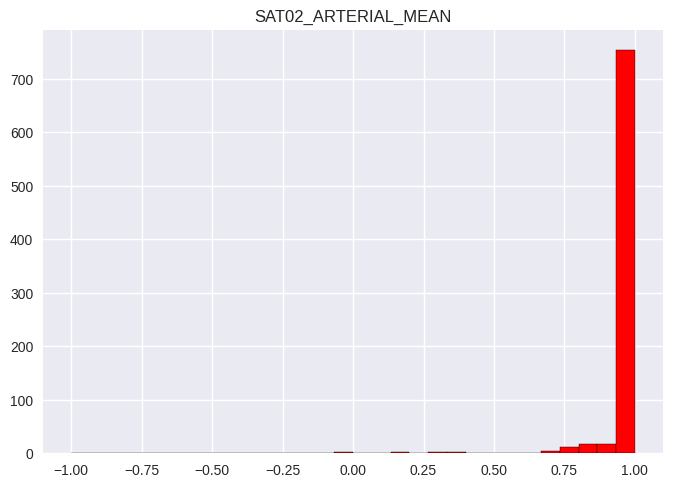

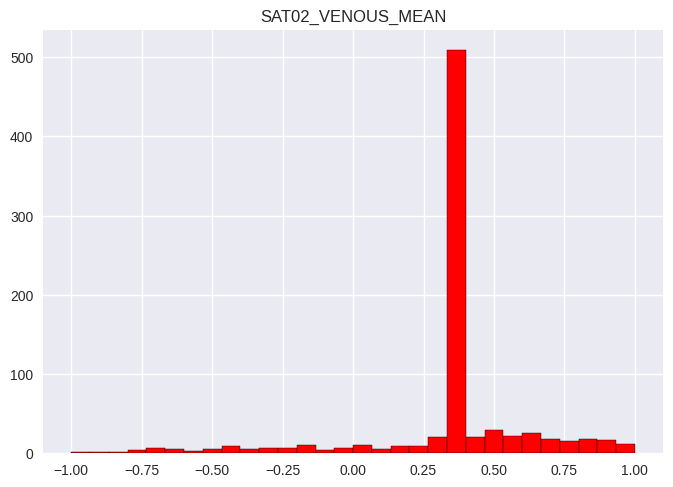

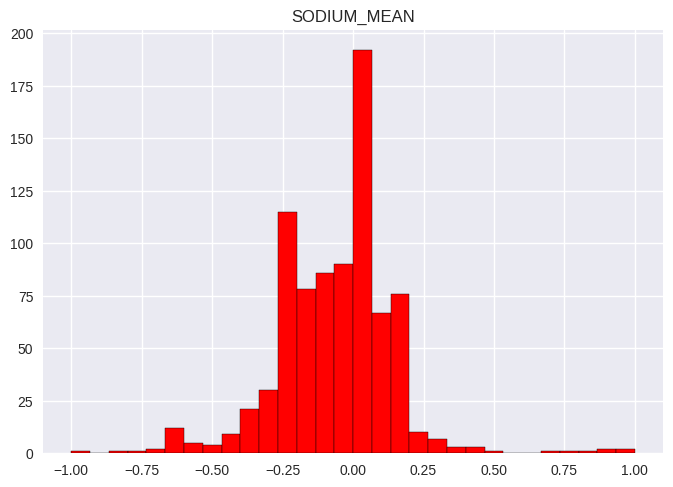

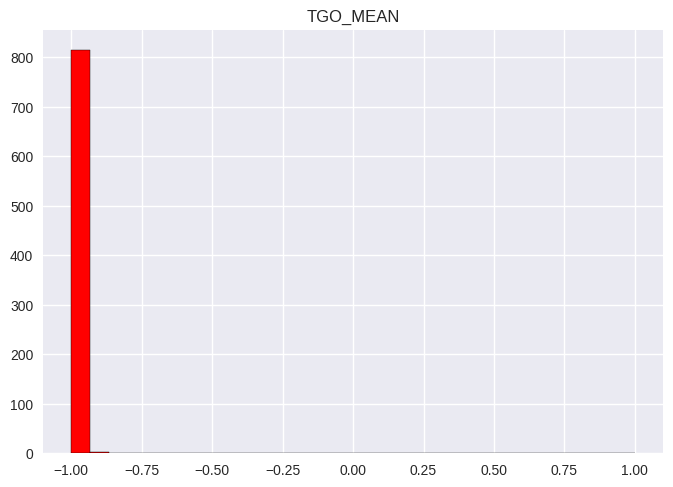

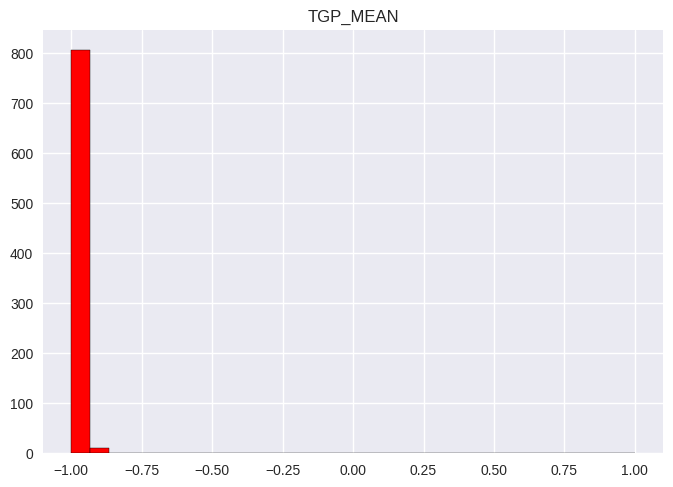

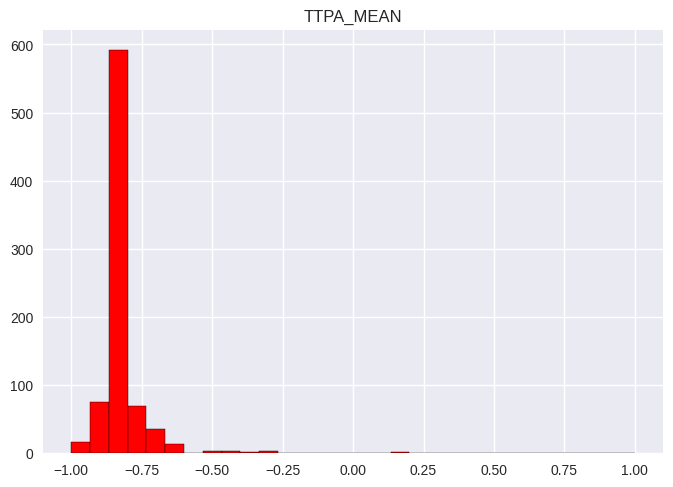

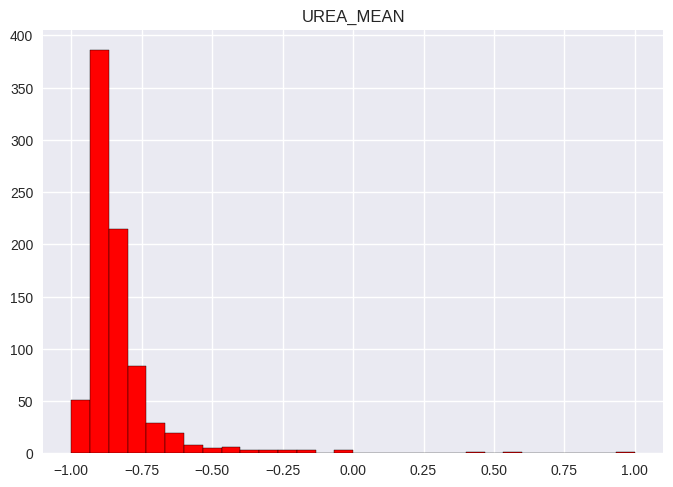

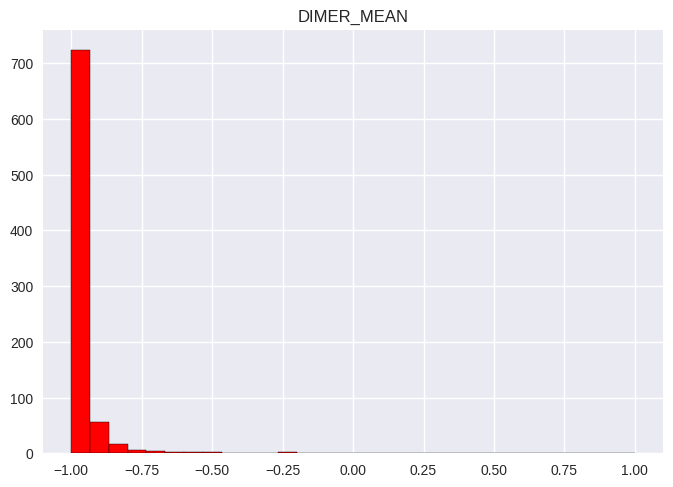

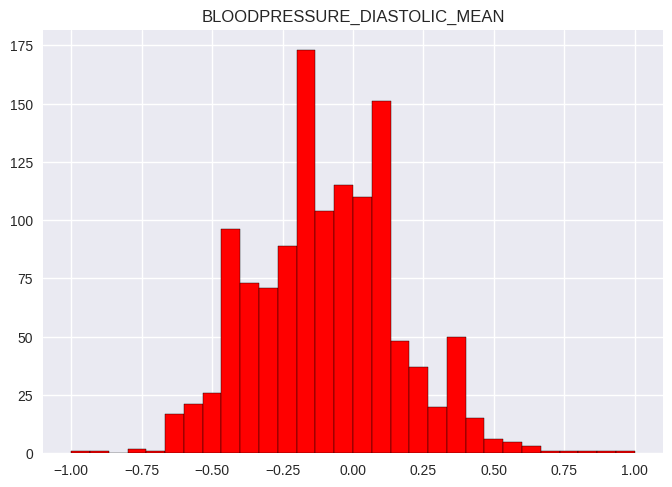

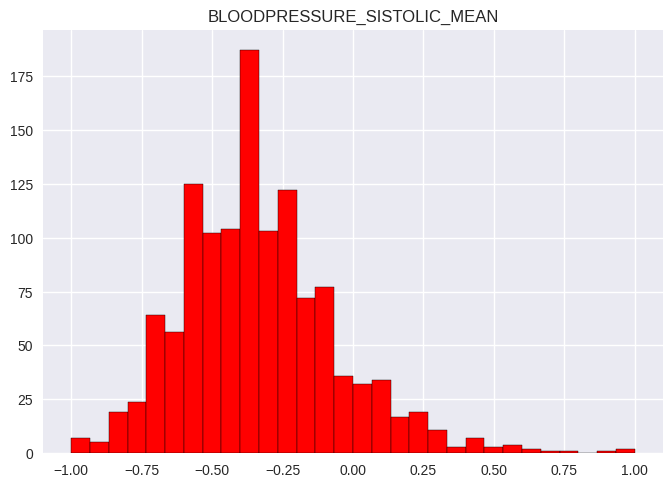

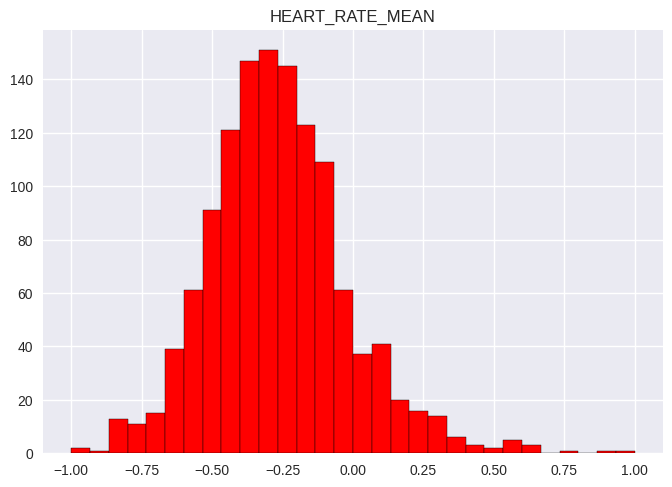

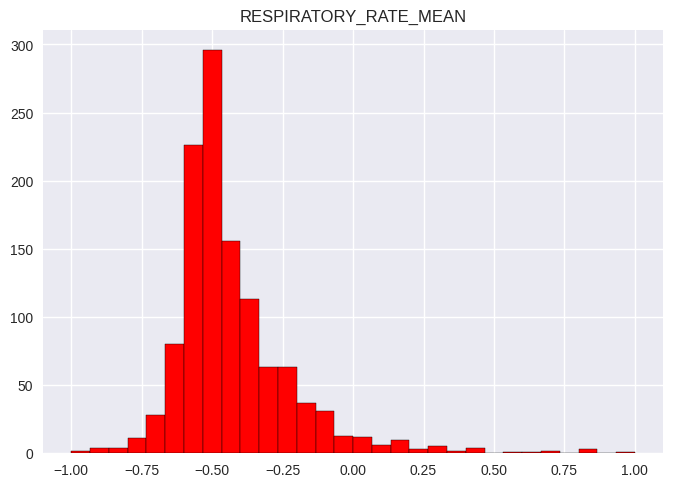

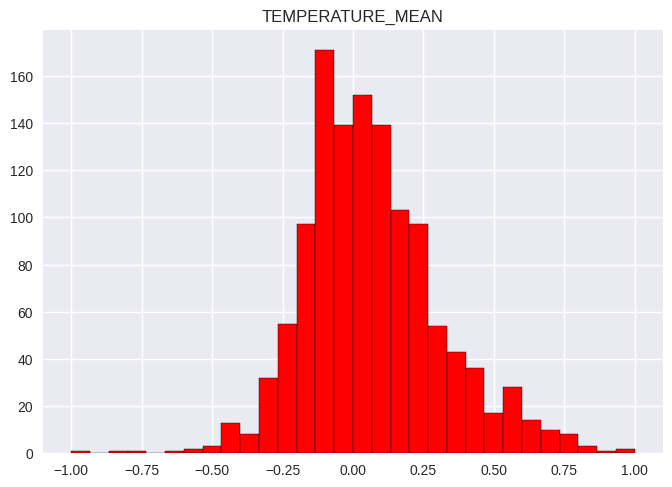

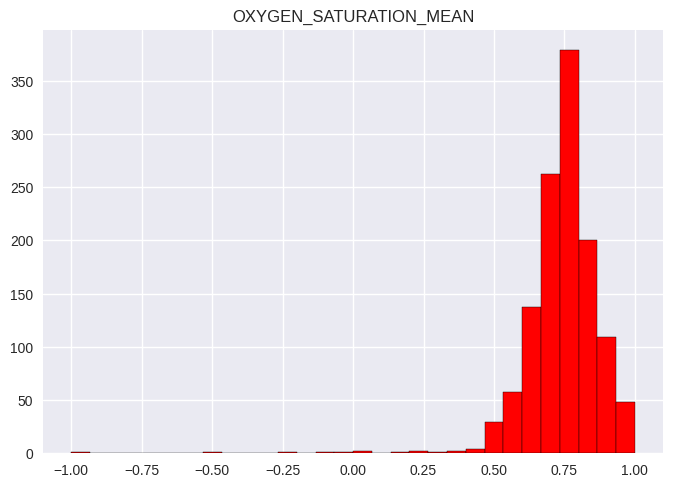

In [ ]:
def basic_hist(feat):
  plt.hist(df[feat], bins=30, color='red', edgecolor='black')
  #plt.hist([math.log(x) if x > 0 else 0 if x == 0 else x for x in df[feat]], bins=30, color='green', edgecolor='black')
  plt.title(feat)
  plt.show()

for x in [y for y in numerical_to_use if 'DIFF' not in y]:
  basic_hist(x)

<Axes: xlabel='DIMER_DIFF', ylabel='UREA_DIFF'>

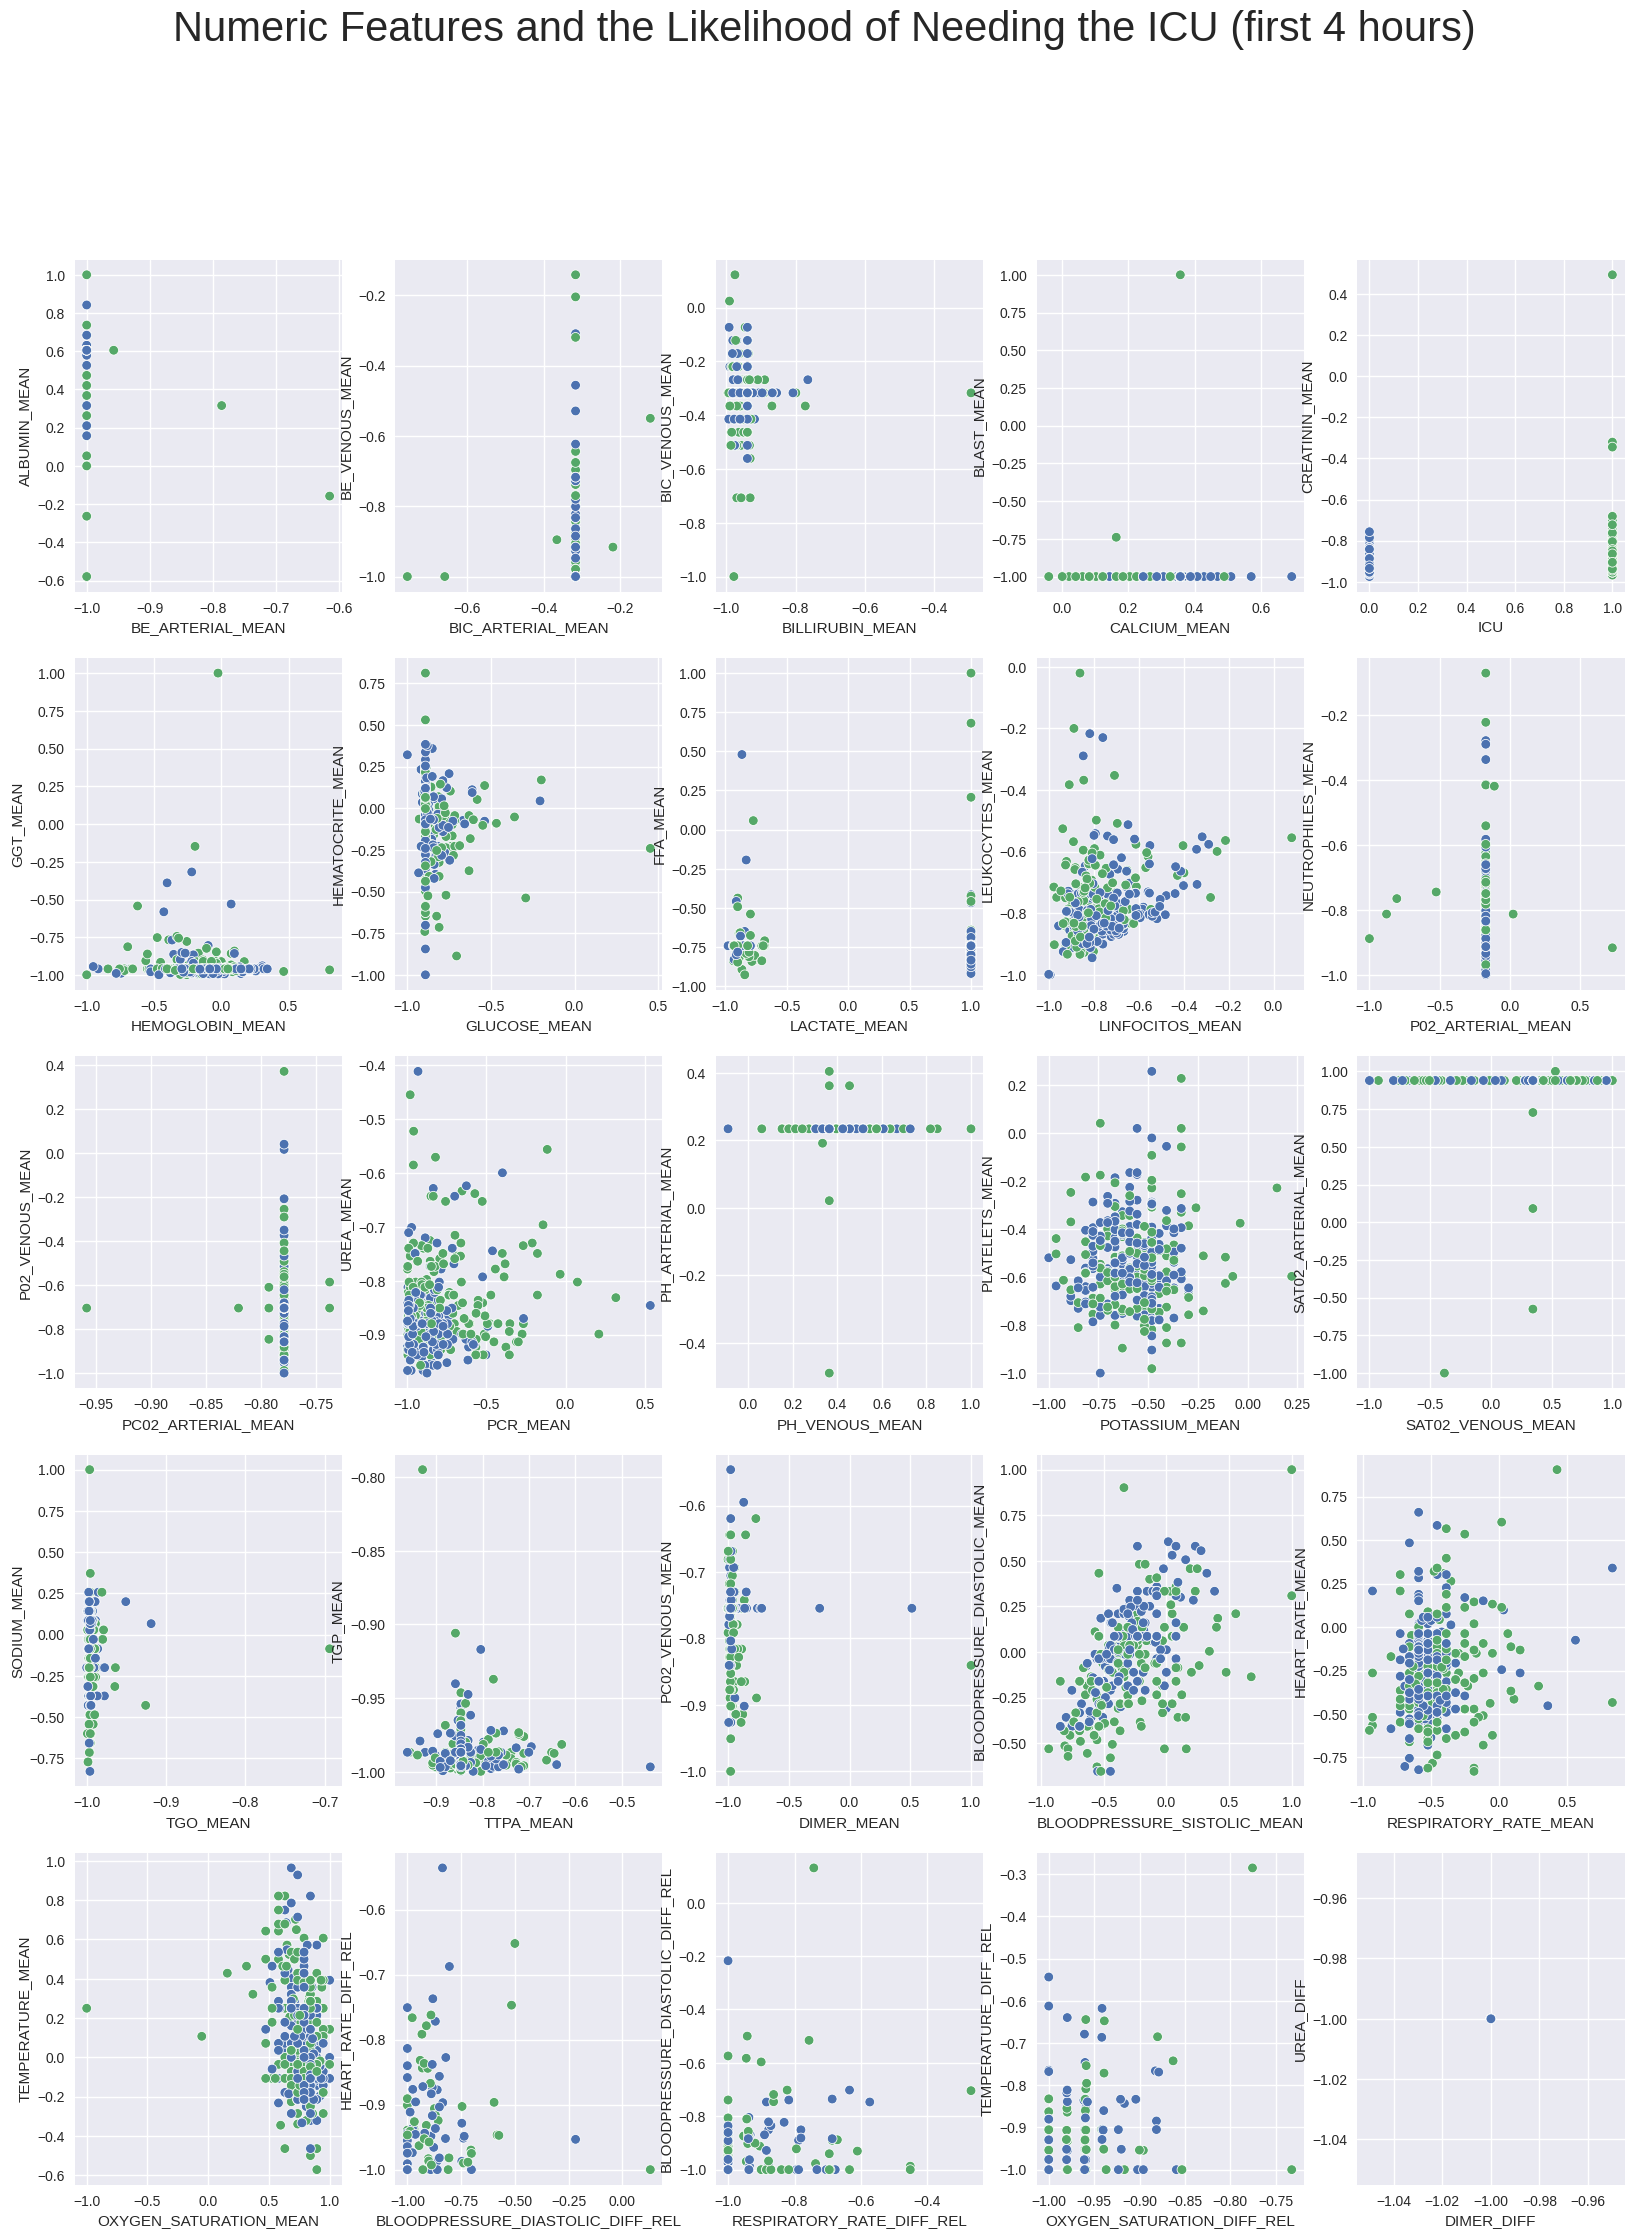

In [ ]:
data = first_hours
fig, axes = plt.subplots(5, 5, figsize=(20,25))
fig.suptitle('Numeric Features and the Likelihood of Needing the ICU (first 4 hours)', fontsize=30)
sns.scatterplot(ax= axes[0,0], data=data, y='ALBUMIN_MEAN', x='BE_ARTERIAL_MEAN', hue='ICU', legend=False)
sns.scatterplot(ax= axes[0,1], data=data, y='BE_VENOUS_MEAN', x='BIC_ARTERIAL_MEAN', hue='ICU', legend=False)
sns.scatterplot(ax= axes[0,2], data=data, y='BIC_VENOUS_MEAN', x='BILLIRUBIN_MEAN', hue='ICU', legend=False)
sns.scatterplot(ax= axes[0,3], data=data, y='BLAST_MEAN', x='CALCIUM_MEAN', hue='ICU', legend=False)
sns.scatterplot(ax= axes[0,4], data=data, y='CREATININ_MEAN', x='INR_MEAN', hue='ICU', legend=False)
sns.scatterplot(ax= axes[1,0], data=data, y='GGT_MEAN', x='HEMOGLOBIN_MEAN', hue='ICU', legend=False)
sns.scatterplot(ax= axes[1,1], data=data, y='HEMATOCRITE_MEAN', x='GLUCOSE_MEAN', hue='ICU', legend=False)
sns.scatterplot(ax= axes[1,2], data=data, y='FFA_MEAN', x='LACTATE_MEAN', hue='ICU', legend=False)
sns.scatterplot(ax= axes[1,3], data=data, y='LEUKOCYTES_MEAN', x='LINFOCITOS_MEAN', hue='ICU', legend=False)
sns.scatterplot(ax= axes[1,4], data=data, y='NEUTROPHILES_MEAN', x='P02_ARTERIAL_MEAN', hue='ICU', legend=False)
sns.scatterplot(ax= axes[2,0], data=data, y='P02_VENOUS_MEAN', x='PC02_ARTERIAL_MEAN', hue='ICU', legend=False)
sns.scatterplot(ax= axes[2,1], data=data, y='UREA_MEAN', x='PCR_MEAN', hue='ICU', legend=False)
sns.scatterplot(ax= axes[2,2], data=data, y='PH_ARTERIAL_MEAN', x='PH_VENOUS_MEAN', hue='ICU', legend=False)
sns.scatterplot(ax= axes[2,3], data=data, y='PLATELETS_MEAN', x='POTASSIUM_MEAN', hue='ICU', legend=False)
sns.scatterplot(ax= axes[2,4], data=data, y='SAT02_ARTERIAL_MEAN', x='SAT02_VENOUS_MEAN', hue='ICU', legend=False)
sns.scatterplot(ax= axes[3,0], data=data, y='SODIUM_MEAN', x='TGO_MEAN', hue='ICU', legend=False)
sns.scatterplot(ax= axes[3,1], data=data, y='TGP_MEAN', x='TTPA_MEAN', hue='ICU', legend=False)
sns.scatterplot(ax= axes[3,2], data=data, y='PC02_VENOUS_MEAN', x='DIMER_MEAN', hue='ICU', legend=False)
sns.scatterplot(ax= axes[3,3], data=data, y='BLOODPRESSURE_DIASTOLIC_MEAN', x='BLOODPRESSURE_SISTOLIC_MEAN', hue='ICU', legend=False)
sns.scatterplot(ax= axes[3,4], data=data, y='HEART_RATE_MEAN', x='RESPIRATORY_RATE_MEAN', hue='ICU', legend=False)
sns.scatterplot(ax= axes[4,0], data=data, y='TEMPERATURE_MEAN', x='OXYGEN_SATURATION_MEAN', hue='ICU', legend=False)
sns.scatterplot(ax= axes[4,1], data=data, y='HEART_RATE_DIFF_REL', x='BLOODPRESSURE_DIASTOLIC_DIFF_REL', hue='ICU', legend=False)
sns.scatterplot(ax= axes[4,2], data=data, y='BLOODPRESSURE_DIASTOLIC_DIFF_REL', x='RESPIRATORY_RATE_DIFF_REL', hue='ICU', legend=False)
sns.scatterplot(ax= axes[4,3], data=data, y='TEMPERATURE_DIFF_REL', x='OXYGEN_SATURATION_DIFF_REL', hue='ICU', legend=False)
sns.scatterplot(ax= axes[4,4], data=data, y='UREA_DIFF', x='DIMER_DIFF', hue='ICU', legend=False)

<Axes: xlabel='OTHER', ylabel='ICU'>

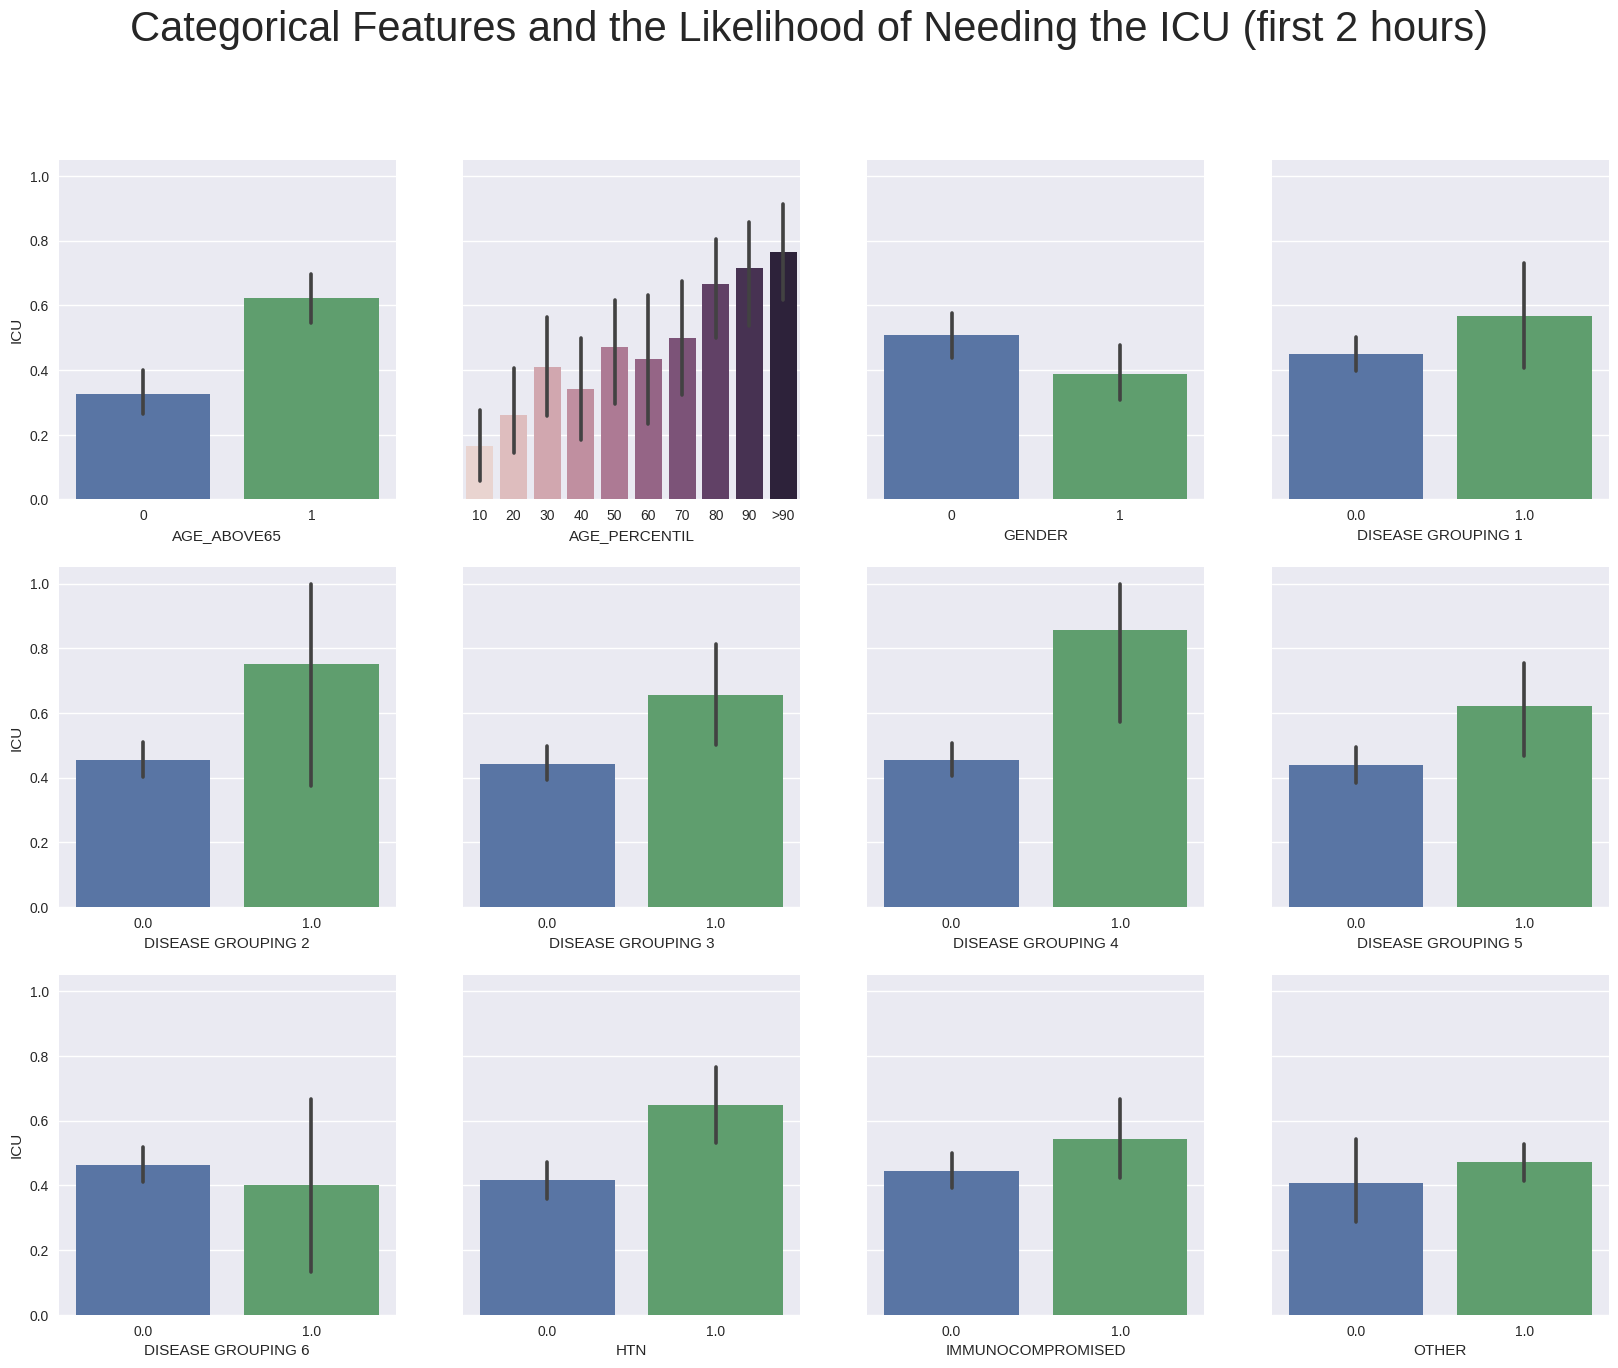

In [ ]:
data = first_hours
fig, axes = plt.subplots(3, 4, figsize=(20,15), sharey=True)
fig.suptitle('Categorical Features and the Likelihood of Needing the ICU (first 2 hours)', fontsize=30)
sns.barplot(ax= axes[0,0], data=data, y='ICU', x='AGE_ABOVE65', hue='AGE_ABOVE65', legend=False)
g = sns.barplot(ax= axes[0,1], data=data, y='ICU', x='AGE_PERCENTIL', hue='AGE_PERCENTIL', legend=False)
g.set_xticks(range(10))
g.set_xticklabels(['10', '20', '30', '40', '50', '60', '70', '80', '90', '>90'])
sns.barplot(ax= axes[0,2], data=data, y='ICU', x='GENDER', hue='GENDER', legend=False)
sns.barplot(ax= axes[0,3], data=data, y='ICU', x='DISEASE GROUPING 1', hue='DISEASE GROUPING 1', legend=False)
sns.barplot(ax= axes[1,0], data=data, y='ICU', x='DISEASE GROUPING 2', hue='DISEASE GROUPING 2', legend=False)
sns.barplot(ax= axes[1,1], data=data, y='ICU', x='DISEASE GROUPING 3', hue='DISEASE GROUPING 3', legend=False)
sns.barplot(ax= axes[1,2], data=data, y='ICU', x='DISEASE GROUPING 4', hue='DISEASE GROUPING 4', legend=False)
sns.barplot(ax= axes[1,3], data=data, y='ICU', x='DISEASE GROUPING 5', hue='DISEASE GROUPING 5', legend=False)
sns.barplot(ax= axes[2,0], data=data, y='ICU', x='DISEASE GROUPING 6', hue='DISEASE GROUPING 6', legend=False)
sns.barplot(ax= axes[2,1], data=data, y='ICU', x='HTN', hue='HTN', legend=False)
sns.barplot(ax= axes[2,2], data=data, y='ICU', x='IMMUNOCOMPROMISED', hue='IMMUNOCOMPROMISED', legend=False)
sns.barplot(ax= axes[2,3], data=data, y='ICU', x='OTHER', hue='OTHER', legend=False)

##ISOLATE DATA FROM FIRST FEW HOURS
- take the first four hours of each patient for an earlier prediction
- not needed for actual modeling

In [ ]:
### FIRST 4 HOURS ###
first4hours = new_df.groupby(['PATIENT_VISIT_IDENTIFIER']).nth([0,1]).reset_index()
first4hours.drop(columns='index')
first4hours['ICU'].value_counts()

ICU
0    378
1    230
Name: count, dtype: int64

#FEATURE SELECTION
- create correlation matrix to weed out similar features
- all median, mean, min, max features have at least .95 correlation
- all diff, diff_rel have at least .95 correlation
- solution -> only use mean and diff

In [ ]:
correlation_matrix = first_hours.corr()
print(correlation_matrix.where(correlation_matrix.ge(0.95)).stack().index.tolist())

[('PATIENT_VISIT_IDENTIFIER', 'PATIENT_VISIT_IDENTIFIER'), ('AGE_ABOVE65', 'AGE_ABOVE65'), ('AGE_PERCENTIL', 'AGE_PERCENTIL'), ('GENDER', 'GENDER'), ('DISEASE GROUPING 1', 'DISEASE GROUPING 1'), ('DISEASE GROUPING 2', 'DISEASE GROUPING 2'), ('DISEASE GROUPING 3', 'DISEASE GROUPING 3'), ('DISEASE GROUPING 4', 'DISEASE GROUPING 4'), ('DISEASE GROUPING 5', 'DISEASE GROUPING 5'), ('DISEASE GROUPING 6', 'DISEASE GROUPING 6'), ('HTN', 'HTN'), ('IMMUNOCOMPROMISED', 'IMMUNOCOMPROMISED'), ('OTHER', 'OTHER'), ('ALBUMIN_MEDIAN', 'ALBUMIN_MEDIAN'), ('ALBUMIN_MEDIAN', 'ALBUMIN_MEAN'), ('ALBUMIN_MEDIAN', 'ALBUMIN_MIN'), ('ALBUMIN_MEDIAN', 'ALBUMIN_MAX'), ('ALBUMIN_MEAN', 'ALBUMIN_MEDIAN'), ('ALBUMIN_MEAN', 'ALBUMIN_MEAN'), ('ALBUMIN_MEAN', 'ALBUMIN_MIN'), ('ALBUMIN_MEAN', 'ALBUMIN_MAX'), ('ALBUMIN_MIN', 'ALBUMIN_MEDIAN'), ('ALBUMIN_MIN', 'ALBUMIN_MEAN'), ('ALBUMIN_MIN', 'ALBUMIN_MIN'), ('ALBUMIN_MIN', 'ALBUMIN_MAX'), ('ALBUMIN_MAX', 'ALBUMIN_MEDIAN'), ('ALBUMIN_MAX', 'ALBUMIN_MEAN'), ('ALBUMIN_MAX',

In [ ]:
first_hours[numerical_to_use + categorical].corr().style.background_gradient(cmap='coolwarm', axis=None)

,ALBUMIN_MEAN,BE_ARTERIAL_MEAN,BE_VENOUS_MEAN,BIC_ARTERIAL_MEAN,BIC_VENOUS_MEAN,BILLIRUBIN_MEAN,BLAST_MEAN,CALCIUM_MEAN,CREATININ_MEAN,FFA_MEAN,GGT_MEAN,GLUCOSE_MEAN,HEMATOCRITE_MEAN,HEMOGLOBIN_MEAN,INR_MEAN,LACTATE_MEAN,LEUKOCYTES_MEAN,LINFOCITOS_MEAN,NEUTROPHILES_MEAN,P02_ARTERIAL_MEAN,P02_VENOUS_MEAN,PC02_ARTERIAL_MEAN,PC02_VENOUS_MEAN,PCR_MEAN,PH_ARTERIAL_MEAN,PH_VENOUS_MEAN,PLATELETS_MEAN,POTASSIUM_MEAN,SAT02_ARTERIAL_MEAN,SAT02_VENOUS_MEAN,SODIUM_MEAN,TGO_MEAN,TGP_MEAN,TTPA_MEAN,UREA_MEAN,DIMER_MEAN,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ICU
ALBUMIN_MEAN,1.000000,-0.303455,-0.085862,-0.127509,-0.005872,-0.323643,0.064547,0.065126,0.051246,-0.361227,-0.300487,-0.207410,0.152399,0.136937,-0.136727,0.109461,0.053384,0.127414,0.022060,-0.120750,0.025541,-0.066743,0.107586,-0.107618,-0.081130,-0.119981,0.040289,0.084943,0.059201,0.064530,0.019009,-0.263889,-0.217494,-0.066304,0.009014,0.008311,-0.013882,0.029702,0.018038,0.007731,0.021854,0.042040,-0.111495,-0.136251,-0.089387,-0.008970,0.032340,-0.035536,-0.049512,-0.082145,0.003414,-0.001948,-0.234636,-0.099656,-0.110234
BE_ARTERIAL_MEAN,-0.303455,1.000000,0.175777,0.367108,0.119552,-0.040059,-0.004652,-0.054705,0.014049,0.049122,0.161119,0.060037,-0.088098,-0.094563,0.042506,-0.129512,-0.050757,-0.026650,-0.042714,0.222774,0.011528,0.134581,0.044836,-0.010646,0.262584,0.028556,-0.050270,0.008904,-0.341881,-0.017691,-0.026185,-0.005002,-0.021395,-0.025022,-0.020157,0.001523,-0.077927,-0.039784,-0.078929,-0.001396,-0.027316,-0.090325,0.084336,0.069500,-0.007740,-0.026649,-0.011856,-0.024588,-0.011074,-0.029771,-0.016403,0.079804,0.092115,0.021056,0.083854
BE_VENOUS_MEAN,-0.085862,0.175777,1.000000,0.088514,0.587602,-0.042904,-0.021525,-0.304145,-0.055656,-0.035670,0.033685,0.044714,-0.046962,-0.066842,0.195203,-0.272607,0.064394,-0.019430,0.077289,0.117004,-0.002962,0.056440,0.073445,0.012657,0.053136,0.424884,-0.005210,-0.069672,0.008417,-0.221640,-0.026830,0.058198,0.143363,-0.066548,0.095724,-0.007627,0.073057,0.087879,-0.053790,0.055953,0.041612,0.037492,0.105124,0.159714,0.024721,0.107552,-0.026704,-0.077272,-0.051235,0.176397,-0.055119,0.090994,0.049722,0.106684,0.104603
BIC_ARTERIAL_MEAN,-0.127509,0.367108,0.088514,1.000000,0.038494,-0.025910,0.002867,-0.037157,0.004752,0.024988,0.070250,0.048613,-0.066168,-0.082426,0.043989,-0.078923,-0.055812,-0.079540,-0.043212,0.256463,0.005193,0.616360,-0.003281,0.050615,0.805581,0.027673,-0.139465,-0.035875,0.213881,-0.019071,-0.063004,0.005373,-0.011513,0.001605,0.009049,0.012727,-0.129380,-0.147589,-0.251090,-0.176965,-0.035388,0.568678,0.026579,0.013898,0.046541,0.016420,0.007305,-0.120817,0.006824,0.018344,0.010107,-0.031567,0.068227,-0.009873,-0.051668
BIC_VENOUS_MEAN,-0.005872,0.119552,0.587602,0.038494,1.000000,0.004417,0.002526,-0.139446,-0.052940,-0.106820,-0.152508,-0.094718,-0.055901,-0.081022,0.098198,-0.059703,-0.049820,0.030829,-0.056733,0.049963,-0.252713,0.018683,0.693562,-0.104524,0.021934,0.073978,-0.036059,-0.093552,-0.022930,-0.321631,0.216305,-0.016960,0.065264,-0.005361,-0.041004,-0.034238,0.082971,0.110993,-0.091764,-0.027533,0.028124,-0.011932,0.060733,0.041150,-0.034360,0.075476,-0.035406,-0.057157,-0.072155,0.109560,-0.037406,0.056214,0.014327,0.043676,-0.098767
BILLIRUBIN_MEAN,-0.323643,-0.040059,-0.042904,-0.025910,0.004417,1.000000,-0.021738,-0.026536,0.016294,0.548561,0.293777,0.041840,0.046912,0.083110,0.125743,-0.009182,0.082990,-0.063122,0.098345,0.000089,-0.009165,-0.008602,-0.008900,0.071866,-0.021979,0.025547,-0.132690,0.040543,0.017157,0.008357,-0.038642,0.389970,0.243683,0.138974,0.109628,-0.026627,-0.042965,-0.100177,0.120371,-0.006415,-0.015597,0.005900,0.020591,0.013885,-0.083659,-0.047129,0.003346,-0.006639,-0.028908,-0.0

<Axes: xlabel='BLOODPRESSURE_SISTOLIC_MEAN', ylabel='ICU'>

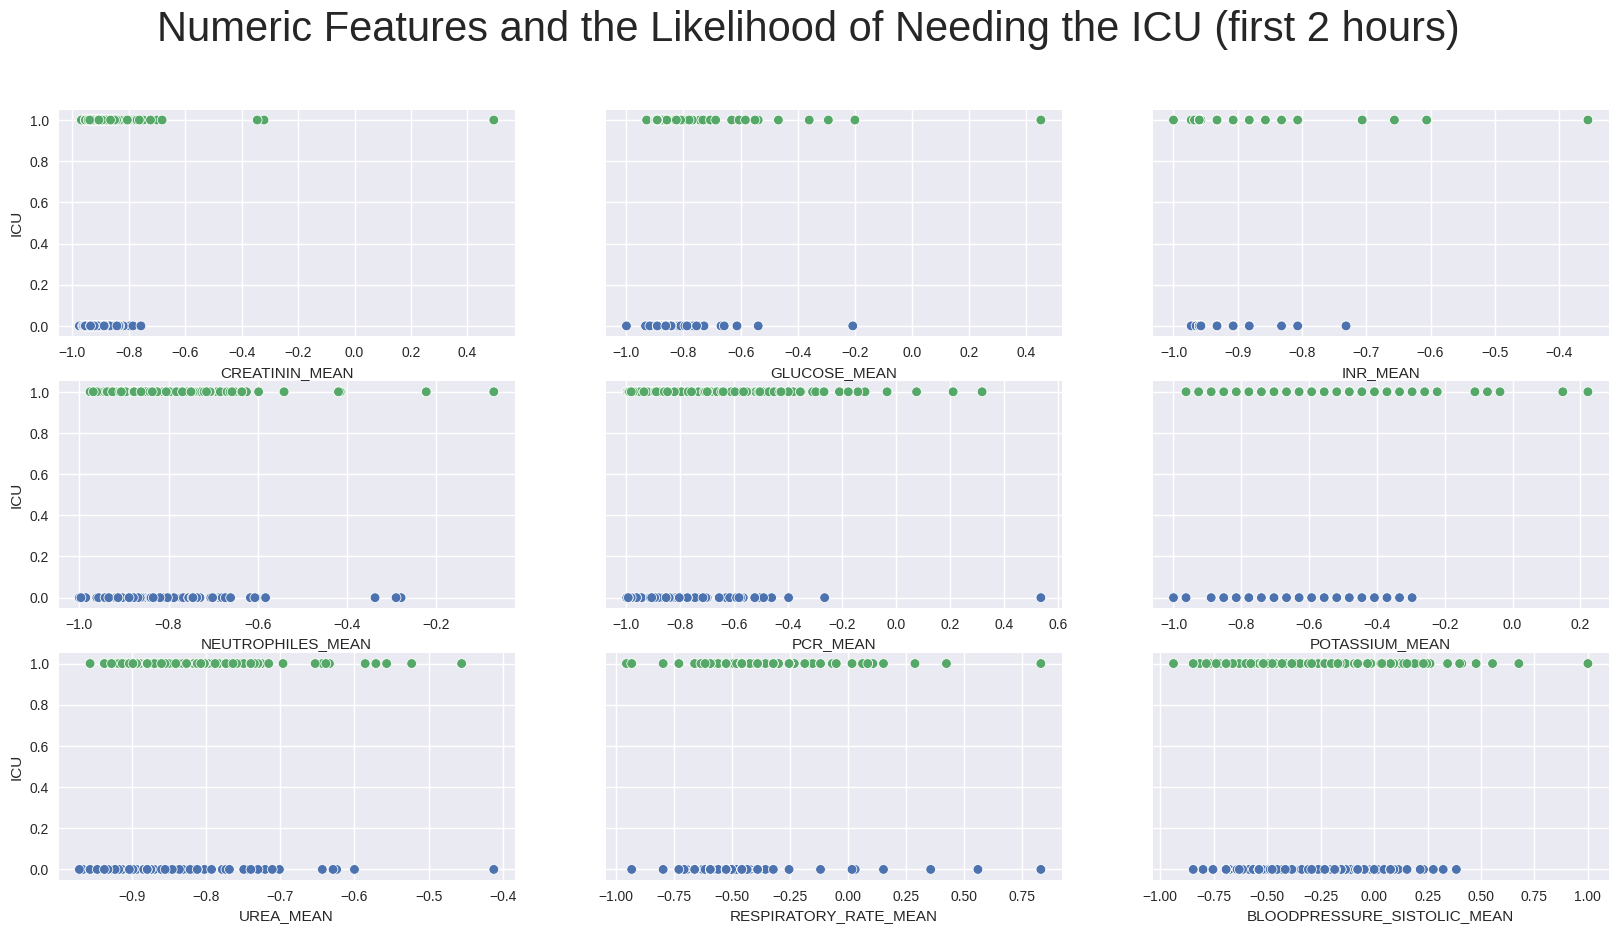

In [ ]:
#CREATININ, GLUCOSE, INR, NEUTROPHILES, PCR, POTASSIUM, UREA, RESPIRATORY_RATE, BLOODPRESSURE_SISTOLIC
data = first_hours
fig, axes = plt.subplots(3, 3, figsize=(20,10), sharey=True)
fig.suptitle('Numeric Features and the Likelihood of Needing the ICU (first 2 hours)', fontsize=30)
sns.scatterplot(ax= axes[0,0], data=data, x='CREATININ_MEAN', y='ICU', hue='ICU', legend=False)
sns.scatterplot(ax= axes[0,1], data=data, x='GLUCOSE_MEAN', y='ICU', hue='ICU', legend=False)
sns.scatterplot(ax= axes[0,2], data=data, x='INR_MEAN', y='ICU', hue='ICU', legend=False)
sns.scatterplot(ax= axes[1,0], data=data, x='NEUTROPHILES_MEAN', y='ICU', hue='ICU', legend=False)
sns.scatterplot(ax= axes[1,1], data=data, x='PCR_MEAN', y='ICU', hue='ICU', legend=False)
sns.scatterplot(ax= axes[1,2], data=data, x='POTASSIUM_MEAN', y='ICU', hue='ICU', legend=False)
sns.scatterplot(ax= axes[2,0], data=data, x='UREA_MEAN', y='ICU', hue='ICU', legend=False)
sns.scatterplot(ax= axes[2,1], data=data, x='RESPIRATORY_RATE_MEAN', y='ICU', hue='ICU', legend=False)
sns.scatterplot(ax= axes[2,2], data=data, x='BLOODPRESSURE_SISTOLIC_MEAN', y='ICU', hue='ICU', legend=False)

#MODELING
- split train and test sets
- fit model
- predict y
- test accuracy and f1 score

1. Random Forest
  - 94.59% accuracy, 0.95 F1 score for Full Dataset
  - 88.29% accuracy, 0.87 F1 score for First 2 Hours
2. Logistic Regression
  - 78.76% accuracy, 0.78 F1 score for Full Dataset
  - 72.15% accuracy, 0.72 F1 score for First 2 Hours
3. Decision Tree
  - 89.38% accuracy, 0.89 F1 score for Full Dataset
  - 82.91% accuracy, 0.82 F1 score for First 2 Hours

###SPLIT DATA
- split data 70/30 train set v test set
- exclude all MEDIAN, MIN, MAX and DIFF_REL features
- exclude PATIENT_VISIT_IDENTIFIER feature

In [ ]:
### TASK 1 ##
x = new_df[numerical_to_use + categorical]
y = new_df['ICU']

ada = ADASYN(random_state=42)
x_res, y_res = ada.fit_resample(x, y)
x_train, x_test, y_train, y_test = train_test_split(x_res, y_res, test_size=0.3, random_state=42)

In [ ]:
### TASK 2 ##
x = first_hours[numerical_to_use + categorical]
y = first_hours['ICU']
x_ftrain, x_test, y_ftrain, y_test = train_test_split(x, y, test_size=0.9, random_state=42)

x_train = pd.concat([new_df[numerical_to_use + categorical], x_ftrain])
y_train = pd.concat([new_df['ICU'], y_ftrain])

ada = ADASYN(random_state=42)
x_train, y_train = ada.fit_resample(x_train, y_train)

###RANDOM FOREST

####***FULL DATASET***
Baseline Accuracy: 86.79%<br/>
Baseline F1 Score: 0.88<br/>
Final Accuracy: 94.59%<br/>
Final F1 Score: 0.95<br/>
Accuracy Gain: 7.8<br/>
F1 Gain: 0.07

####***FIRST 2 HOURS***
Baseline Accuracy: 64.49%<br/>
Baseline F1 Score: 0.59<br/>
Final Accuracy: 88.29%<br/>
Final F1 Score: 0.87<br/>
Accuracy Gain: 23.8<br/>
F1 Gain: 0.28

Accuracy: 88.29113924050634
F1 Score: 0.872852233676976


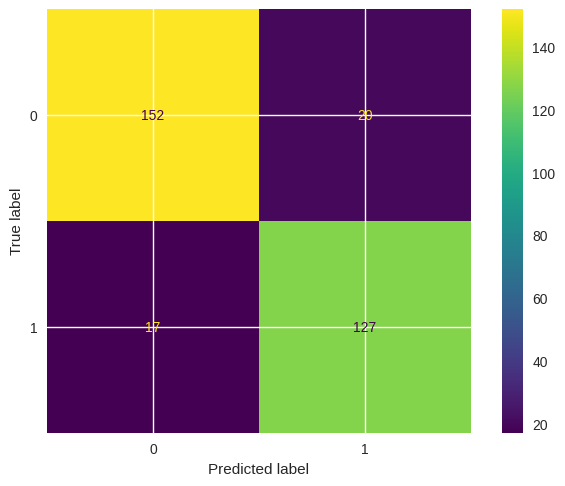

In [ ]:
rf_classifier = RandomForestClassifier(random_state=42, n_estimators=120) #n_estimators=75
rf_classifier.fit(x_train, y_train)

# Predict the target variable for the testing set and calculate accuracy
y_pred_rf = rf_classifier.predict(x_test)
accuracy = accuracy_score(y_test, y_pred_rf)*100
print('Accuracy:', accuracy)
#print(f"Accuracy: {accuracy:.2f}")
f1_score = metrics.f1_score(y_test, y_pred_rf)
#print(f"F1 Score: {f1_score:.2f}")
print("F1 Score:", f1_score)

# Confusion Matrix
confusion_matrix = metrics.confusion_matrix(y_pred_rf, y_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=[0, 1])
cm_display.plot()
plt.show()

### FULL DATASET ###
#** tested by Accuracy and F1 Score **#
#Base level - categorical encoding, drop missing values, remove rows where target=1, change target values to last WINDOW value: 86.792, 0.884
#Categorical encoding, replace missing values with 1: 73.759, 0.519
#Categorical encoding, backfill and frontfill imputation: 92.4, 0.87
#Categorical encoding  more aligned with hours in WINDOW, backfill/frontfill imputation: 92.4, 0.87
#Categorical encoding, backfill/frontfill imputation, scaling: 92.4, 0.87
#Categorical encoding, backfill/frontfill imputation, scaling, smote: 95.586, 0.959
#Categorical encoding, backfill/frontfill imputation, scaling, smote, omit patient ID: 95.971, 0.96
#Categorical encoding, backfill/frontfill imputation, scaling, smote, feature omition: 94.589, 0.947
#Categorical encoding, backfill/frontfill imputation, scaling, smote, feature omition, hyperparameter tuning: 94.589, 0.947

### FIRST 2 HOURS ###
#** tested by Accuracy and F1 Score **#
#Base level - categorical encoding, drop missing values, remove rows where target=1, change target values to last WINDOW value: not possible -> hardly any windows 1-2
#Categorical encoding, replace missing values with 1: 67.491, 0.586
#categorical encoding, backfill and frontfill imputation: 84.698, 0.833
#categorical encoding, backfill and frontfill imputation, scaling: 84.698, 0.833
#categorical encoding, backfill and frontfill imputation, scaling, smote: 85.765, 0.846
#categorical encoding, scaling, backfill and frontfill imputation, change target value, omit patient ID: 85.053, 0.847
#categorical encoding, scaling, backfill and frontfill imputation, change target value, feature omition: 87.342, 0.861
#categorical encoding, scaling, backfill and frontfill imputation, change target value, feature omition, hyperparameter tuning: 88.291, 0.873

###LOGISTIC REGRESSION

####***FULL DATASET***
Baseline Accuracy: 84.91%<br/>
Baseline F1 Score: 0.87<br/>
Final Accuracy: 78.76%<br/>
Final F1 Score: 0.78<br/>
Accuracy Loss: 6.15<br/>
F1 Loss: 0.09

####***FIRST 2 HOURS***
Baseline Accuracy: 68.91%<br/>
Baseline F1 Score: 0.63<br/>
Final Accuracy: 72.15%<br/>
Final F1 Score: 0.72<br/>
Accuracy Gain: 3.24<br/>
F1 Gain: 0.09

Accuracy: 72.15
F1 Score: 0.72


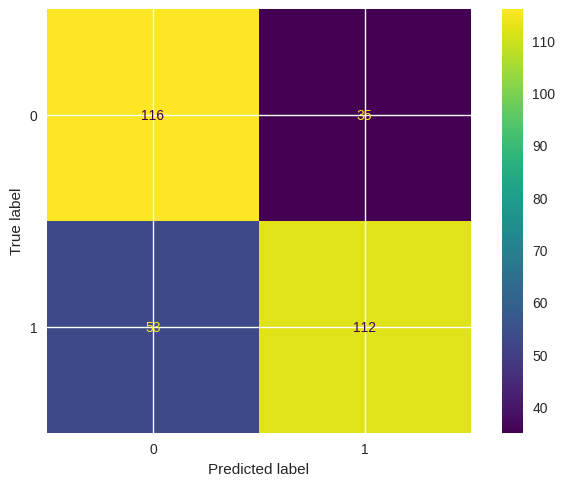

In [ ]:
logreg_model = LogisticRegression(random_state=42, C=5, solver='liblinear') #C=5, solver='liblinear'
logreg_model.fit(x_train, y_train)

# Predict the target variable for the testing set and calculate accuracy
y_pred_lg = logreg_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred_lg)*100
print(f"Accuracy: {accuracy:.2f}")
f1_score = metrics.f1_score(y_test, y_pred_lg)
print(f"F1 Score: {f1_score:.2f}")

# Confusion Matrix
confusion_matrix = metrics.confusion_matrix(y_pred_lg, y_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()

### FULL DATASET ###
#** tested by Accuracy and F1 Score **#
#Base level - categorical encoding, drop missing values, remove rows where target=1, change target values to last WINDOW value: 84.906, 0.865
#Categorical encoding, replace missing values with 1: 70.686, 0.446
#Categorical encoding, backfill and frontfill imputation: 83.135, 0.703
#Categorical encoding  more aligned with hours in WINDOW, backfill/frontfill imputation: 82.66, 0.692
#Categorical encoding, backfill/frontfill imputation, scaling: 81.948, 0.678
#Categorical encoding, backfill/frontfill imputation, scaling, smote: 83.701, 0.849
#Categorical encoding, backfill/frontfill imputation, scaling, smote, omit patient ID: 82.784, 0.827
#Categorical encoding, backfill/frontfill imputation, scaling, smote, feature omition: 78.755, 0.783
#Categorical encoding, backfill/frontfill imputation, scaling, smote, feature omition, hyperparameter tuning: 78.755, 0.783

### FIRST 2 HOURS ###
#** tested by Accuracy and F1 Score **#
#Base level - categorical encoding, drop missing values: not possible -> no consecutive windows 1-4
#Categorical encoding, replace missing values with 1: 68.905, 0.630
#categorical encoding, backfill and frontfill imputation: 73.31, 0.689
#categorical encoding, backfill and frontfill imputation, scaling: 71.886, 0.669
#categorical encoding, backfill and frontfill imputation, scaling, smote: 70.107, 0.689
#categorical encoding, scaling, backfill and frontfill imputation, change target value, omit patient ID: 72.598, 0.739
#categorical encoding, scaling, backfill and frontfill imputation, change target value, feature omition: 71.519, 0.715
#categorical encoding, scaling, backfill and frontfill imputation, change target value, feature omition, hyperparameter tuning: 72.152, 0.718

###DECISION TREE

####***FULL DATASET***
Baseline Accuracy: 84.91%<br/>
Baseline F1 Score: 0.87<br/>
Final Accuracy: 89.38%<br/>
Final F1 Score: 0.89<br/>
Accuracy Gain: 4.47<br/>
F1 Gain: 0.02

####***FIRST 2 HOURS***
Baseline Accuracy: 69.26%<br/>
Baseline F1 Score: 0.63<br/>
Final Accuracy: 82.91%<br/>
Final F1 Score: 0.82<br/>
Accuracy Loss: 13.65<br/>
F1 Gain: 0.19

Accuracy: 82.91
F1 Score: 0.82


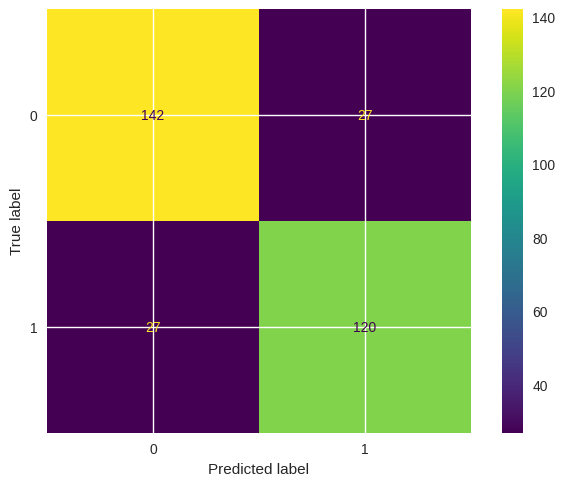

In [ ]:
dt_classifier = DecisionTreeClassifier(random_state=42, criterion='entropy', min_samples_split=3) #criterion='entropy', min_samples_split=3
dt_classifier.fit(x_train, y_train)

# Predict the target variable for the testing set and calculate accuracy
y_pred_dt = dt_classifier.predict(x_test)
accuracy = accuracy_score(y_test, y_pred_dt)*100
print(f"Accuracy: {accuracy:.2f}")
f1_score = metrics.f1_score(y_test, y_pred_dt)
print(f"F1 Score: {f1_score:.2f}")

# Confusion Matrix
confusion_matrix = metrics.confusion_matrix(y_pred_dt, y_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])
cm_display.plot()
plt.show()

### FULL DATASET ###
#** tested by Accuracy and F1 Score **#
#Base level - categorical encoding, drop missing values, remove rows where target=1, change target values to last WINDOW value: 84.906, 0.867
#Categorical encoding, replace missing values with 1: 76.122, 0.622
#Categorical encoding, backfill and frontfill imputation: 86.223, 0.772
#Categorical encoding  more aligned with hours in WINDOW, backfill/frontfill imputation: 86.223, 0.772
#Categorical encoding, backfill/frontfill imputation, scaling: 86.223, 0.772
#Categorical encoding, backfill/frontfill imputation, scaling, smote: 87.776, 0.883
#Categorical encoding, backfill/frontfill imputation, scaling, smote, omit patient ID: 83.883, 0.838
#Categorical encoding, backfill/frontfill imputation, scaling, smote, feature omition: 89.377, 0.893
#Categorical encoding, backfill/frontfill imputation, scaling, smote, feature omition, hyperparameter tuning: 89.377, 0.893

### FIRST 2 HOURS ###
#** tested by Accuracy and F1 Score **#
#Base level - categorical encoding, drop missing values: not possible -> no consecutive windows 1-4
#Categorical encoding, replace missing values with 1: 69.258, 0.63
#categorical encoding, backfill and frontfill imputation: 79.004, 0.770
#categorical encoding, backfill and frontfill imputation, scaling: 79.004, 0.770
#categorical encoding, backfill and frontfill imputation, scaling, smote: 82.206, 0.808
#categorical encoding, scaling, backfill and frontfill imputation, change target value, omit patient ID: 76.512, 0.746
#categorical encoding, scaling, backfill and frontfill imputation, change target value, feature omition: 77.848, 0.759
#categorical encoding, scaling, backfill and frontfill imputation, change target value, feature omition, hyperparameter tuning:82.911, 0.816

#Optimization
###Grid Search Hyperparameter Tuning
- Run Grid Search on an array of hyperparameters to figure out which hyperparameter combination leads to the best model
- Problem: Grid Search led to overfitting, so proposed hyperparameters resulted in a less accurate model
- Solution: Plug in hyperparameters one by one to test if accuracy increases/decreases

In [ ]:
param_lg_grid = {'C':[1, 0.1, 5, 3, 10],
                 'penalty': ['l1', 'elasticnet', 'l2'],
                 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
                 'multi_class': ['auto', 'ovr', 'multinomial']}

# Initialize GridSearchCV
# pass model, list of parameter, and number of permiatations
grid_lg_search = GridSearchCV(LogisticRegression(random_state=42), param_lg_grid, cv=5, n_jobs=-1)

# Perform grid search
grid_lg_search.fit(x_train, y_train)

# Get the best hyperparameters
best_lg_params = grid_lg_search.best_params_
print(best_lg_params)

# Initialize and train logistic regression model with best hyperparameters
best_lg_model = LogisticRegression(**best_lg_params, random_state=42)
best_lg_model.fit(x_train, y_train)

# Make predictions on the testing set
y_pred = best_lg_model.predict(x_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
f1_score = metrics.f1_score(y_test, y_pred)
print(f"F1 Score: {f1_score:.2f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (

{'C': 5, 'multi_class': 'auto', 'penalty': 'l1', 'solver': 'saga'}
Accuracy: 0.8295652173913044
F1 Score: 0.8243727598566308


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
param_dt_grid = {'criterion':['gini', 'entropy', 'log_loss'],
                 'min_samples_split':[2,3,4,5],
                 'min_samples_leaf':[1,2,3,4,5]}
grid_dt_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_dt_grid, cv=5, n_jobs=-1)
grid_dt_search.fit(x_train, y_train)
best_dt_params = grid_dt_search.best_params_
print(best_dt_params)

best_dt_model = DecisionTreeClassifier(**best_dt_params, random_state=42)
best_dt_model.fit(x_train, y_train)

# Make predictions on the testing set
y_pred = best_dt_model.predict(x_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
f1_score = metrics.f1_score(y_test, y_pred)
print(f"F1 Score: {f1_score:.2f}")

{'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.83
F1 Score: 0.82


In [ ]:
#Random Forest

dataframe = new_df
for f in numerical_to_use:
  X_op = dataframe[numerical_to_use + categorical].drop(columns=[f])
  y_op = dataframe['ICU']

  #ada = ADASYN(random_state=42)
  #X_res_op, y_res_op = ada.fit_resample(X_op, y_op)

  #X_train_op, X_test_op, y_train_op, y_test_op = train_test_split(X_res_op, y_res_op, test_size=0.2, random_state=42)
  X_train_op, X_test_op, y_train_op, y_test_op = train_test_split(X_op, y_op, test_size=0.3, random_state=42)

  rf_classifier = RandomForestClassifier(random_state=42, n_estimators=75)
  rf_classifier.fit(X_train_op, y_train_op)
  y_pred_op = rf_classifier.predict(X_test_op)

  # Calculate accuracy
  accuracy = accuracy_score(y_test_op, y_pred_op)*100
  f1_score = metrics.f1_score(y_test_op, y_pred_op)
  if accuracy > 94.13919413919413:
  #if np.isclose(accuracy, 77.35849056603774):
    print("Better than preprocessed: ", f, accuracy, f1_score)

  #'BILLIRUBIN_MEAN', 'FFA_MEAN', 'GGT_MEAN', 'LINFOCITOS_MEAN', 'LEUKOCYTES_MEAN', 'NEUTROPHILES_MEAN', 'P02_VENOUS_MEAN', 'PLATELETS_MEAN',
  #'SAT02_VENOUS_MEAN', 'TGO_MEAN', 'TGP_MEAN', 'TTPA_MEAN', 'HEART_RATE_DIFF_REL', 'TEMPERATURE_DIFF_REL', 'PH_ARTERIAL_MEAN'

#Better than preprocessed:  ALBUMIN_MEAN 70.75471698113208 0.6666666666666666
#Better than preprocessed:  CREATININ_MEAN 72.64150943396226 0.7184466019417476
#Better than preprocessed:  FFA_MEAN 73.58490566037736 0.72
#Better than preprocessed:  GGT_MEAN 73.58490566037736 0.7142857142857142
#Better than preprocessed:  GLUCOSE_MEAN 70.75471698113208 0.686868686868687
#Better than preprocessed:  HEMATOCRITE_MEAN 70.75471698113208 0.686868686868687
#Better than preprocessed:  LINFOCITOS_MEAN 71.69811320754717 0.6938775510204083
#Better than preprocessed:  NEUTROPHILES_MEAN 71.69811320754717 0.6808510638297872
#Better than preprocessed:  P02_VENOUS_MEAN 71.69811320754717 0.6938775510204083
#Better than preprocessed:  POTASSIUM_MEAN 70.75471698113208 0.6666666666666666
#Better than preprocessed:  SAT02_ARTERIAL_MEAN 70.75471698113208 0.6666666666666666
#Better than preprocessed:  SAT02_VENOUS_MEAN 71.69811320754717 0.6808510638297872
#Better than preprocessed:  DIMER_MEAN 70.75471698113208 0.6593406593406594



In [ ]:
#Save and Load ML model that you just created

#joblib.dump(model, filename) -> saved as pk1
#loaded_model = joblib.load(filename) -> load model
#new_y_pred = loaded_model.predict(x_new)